# Plot temporal fluctuation scaling

In [1]:
import os
import re
import sys
import json
import warnings
import matplotlib
import subprocess
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import matplotlib.colors as mcolors
import matplotlib.transforms as mtransforms

from scipy.optimize import curve_fit
from scipy.stats import percentileofscore

sys.path.append('../modules')
import plot_optimal_window as plt_ow
import plot_temporal_fluctuation_scaling as plt_tfs
import estimate_temporal_fluctuation_scaling as etfs

warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

colors = ["blue", "green", "red", "purple", "orange", "brown", "pink", "olive", "gray", "cyan"]

In [2]:
%matplotlib inline

## Global variables

In [3]:
input_path_raw = "../input_files/raw_data"
input_path_processed = "../input_files/processed_data"
input_path_data_dictionary = "../input_files/data_dictionary"
log_path = "../logs"
output_path = "../output_files"
input_generation_date = "2023-04-11"

In [4]:
# Stock indexes
list_stock_indexes = {
    "^GSPC" : "Standard and Poor's 500", # S&P 500 (United States)
    "^DJI" : "Dow Jones Industrial Average", # Dow Jones Industrial Average (United States)
    "^W5000" : "Wilshire 5000", # Wilshire 5000 (United States)
    "^GSPTSE" : "Toronto Stock Exchange Composite index", # S&P/TSX Composite index (Canada)
    "^GDAXI" : "German Stock index", # DAX Performance index (Germany)
    "^FTSE" : "Financial Times Stock Exchange 100", # FTSE 100 (United Kingdom)
    "^FCHI" : "Continuous Assisted Quotation 40", # CAC 40 (France)
    "^IXIC" : "National Association of Securities Dealers Automated Quotation Composite", # NASDAQ Composite (United States)
    "IMOEX.ME" : "Moscow Stock Exchange", # MOEX Russia Index (Russia)
    "^N225" : "Nikkei Heikin Kabuka Stock Exchange 225", # Nikkei 225 (Japan)
    "^STI" : "Straits Times Index 30", # STI Index (Singapore)
    "^BVSP" : "Sao Paulo Stock Exchange", # IBOVESPA (Brazil)
    "^MERV" : "Buenos Aires Stock Exchange" # MERVAL (Argentine)
}

In [5]:
# Currencies
list_currencies = {
    "KWDUSD=X" : "Currency exchange rate from Kuwaiti Dinar to U.S. dollar", # KWD/USD
    "BHDUSD=X" : "Currency exchange rate from Bahraini Dinar to U.S. dollar", # BHD/USD
    "OMRUSD=X" : "Currency exchange rate from Omani Rial to U.S. dollar", # OMR/USD    
    "JODUSD=X" : "Currency exchange rate from Jordanian Dinar to U.S. dollar", # JOD/USD
    "KYDUSD=X" : "Currency exchange rate from Cayman Islands dollar to U.S. dollar", # KYD/USD
    "GBPUSD=X" : "Currency exchange rate from U.K. pound sterling to U.S. dollar", # GBP/USD
    "CHFUSD=X" : "Currency exchange rate from swiss franc to U.S. dollar", # CHF/USD
    "EURUSD=X" : "Currency exchange rate from euro to U.S. dollar", # EUR/USD
    "SGD=X" : "Currency exchange rate from U.S. dollar to Singapore dollar", # USD/SGD
    "CAD=X" : "Currency exchange rate from U.S. dollar to Canadian dollar", # USD/CAD
    "AUD=X" : "Currency exchange rate from U.S. dollar to Australian dollar", # USD/AUD
    "NZD=X" : "Currency exchange rate from U.S. dollar to New Zealand dollar", # USD/NZD
    "MYR=X" : "Currency exchange rate from U.S. dollar to malaysian ringgit", # USD/MYR    
    "BRL=X" : "Currency exchange rate from U.S. dollar to Brazilian real", # USD/BRL    
    "CNY=X" : "Currency exchange rate from U.S. dollar to chinese renminbi", # USD/CNY
    "HKD=X" : "Currency exchange rate from U.S. dollar to Hong Kong dollar", # USD/HKD
    "SEK=X" : "Currency exchange rate from U.S. dollar to swedish krona", # USD/SEK
    "ZAR=X" : "Currency exchange rate from U.S. dollar to South African rand", # USD/ZAR
    "MXN=X" : "Currency exchange rate from U.S. dollar to mexican peso", # USD/MXN
    "THB=X" : "Currency exchange rate from U.S. dollar to thai baht", # USD/THB
    "PHP=X" : "Currency exchange rate from U.S. dollar to philippines peso", # USD/PHP
    "RUB=X" : "Currency exchange rate from U.S. dollar to russian ruble", # USD/RUB
    "INR=X" : "Currency exchange rate from U.S. dollar to indian rupee", # USD/INR
    "JPY=X" : "Currency exchange rate from U.S. dollar to japanese yen", # USD/JPY    
    "HUF=X" : "Currency exchange rate from U.S. dollar to hungarian forints", # USD/HUF
    "COP=X" : "Currency exchange rate from U.S. dollar to colombian peso", # USD/COP
    "IDR=X" : "Currency exchange rate from U.S. dollar to indonesian rupiah", # USD/IDR
    "EURCOP=X" : "Currency exchange rate from euro to colombian peso" # EUR/COP
}

## Load time series

In [6]:
df_stock_indexes = pd.read_csv("{}/df_stock_index_{}.csv".format(input_path_processed, re.sub("-", "", input_generation_date)), low_memory = False)
df_currencies = pd.read_csv("{}/df_currency_{}.csv".format(input_path_processed, re.sub("-", "", input_generation_date)), low_memory = False)
df_stock_indexes_parameters = pd.read_csv("{}/df_stock_index_parameters_{}.csv".format(input_path_processed, re.sub("-", "", input_generation_date)), low_memory = False)
df_currencies_parameters = pd.read_csv("{}/df_currency_parameters_{}.csv".format(input_path_processed, re.sub("-", "", input_generation_date)), low_memory = False)
df_stock_indexes_tfs_parameters = pd.read_csv("{}/df_stock_index_tfs_parameters_{}.csv".format(input_path_processed, re.sub("-", "", input_generation_date)), low_memory = False)
df_currencies_tfs_parameters = pd.read_csv("{}/df_currency_tfs_parameters_{}.csv".format(input_path_processed, re.sub("-", "", input_generation_date)), low_memory = False)
df_optimal_stock_indexes = pd.read_csv("{}/df_optimal_window_stock_index_{}.csv".format(input_path_processed, re.sub("-", "", input_generation_date)), low_memory = False)
df_optimal_currencies = pd.read_csv("{}/df_optimal_window_currency_{}.csv".format(input_path_processed, re.sub("-", "", input_generation_date)), low_memory = False)

In [7]:
if os.path.exists("{}/{}".format(output_path, re.sub("-", "", input_generation_date))) == False:
    os.mkdir("{}/{}".format(output_path, re.sub("-", "", input_generation_date)))
if os.path.exists("{}/{}/stock_index".format(output_path, re.sub("-", "", input_generation_date))) == False:
    os.mkdir("{}/{}/stock_index".format(output_path, re.sub("-", "", input_generation_date)))
if os.path.exists("{}/{}/currency".format(output_path, re.sub("-", "", input_generation_date))) == False:
    os.mkdir("{}/{}/currency".format(output_path, re.sub("-", "", input_generation_date)))

Generated plot for ^W5000 and time series absolute log-return
Generated plot for ^W5000 and time series log-return
Generated plot for ^W5000 and time series log-return volatility


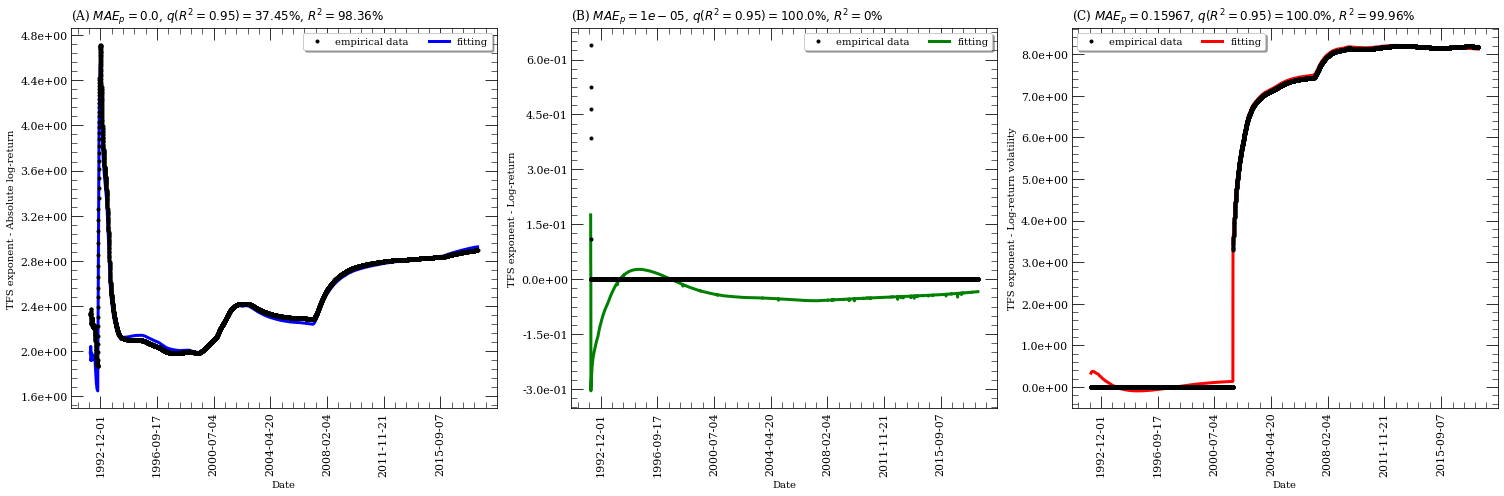

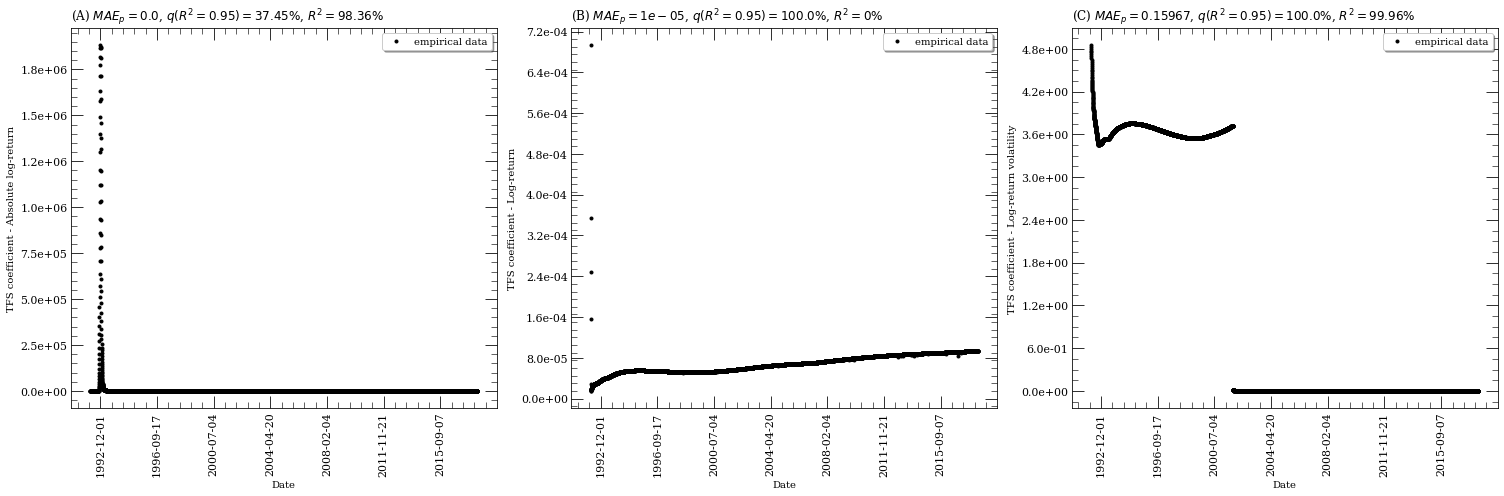

In [8]:
df_graph = plt_tfs.plot_tfs_evolution(
    df_fts = df_stock_indexes,
    df_optimal = df_optimal_stock_indexes,
    df_tfs = df_stock_indexes_tfs_parameters,
    interval = "days",
    threshold = 0.95,
    symbols = ["^W5000"],
    width = 21,
    height = 7,
    all_data = True,
    markersize = 3,
    fontsize_labels = 11,
    fontsize_legend = 10,
    usetex = False,
    n_cols = 4,
    n_x_breaks = 10,
    n_y_breaks = 10,
    fancy_legend = True,
    dpi = 200,
    save_figures = True,
    output_path = "{}/{}/stock_index".format(output_path, re.sub("-", "", input_generation_date)),
    information_name = re.sub("(\^)|(=X)", "", "^W5000"),
    input_generation_date = input_generation_date
)

Generated plot for ^GSPC and time series absolute log-return
Generated plot for ^GSPC and time series log-return volatility


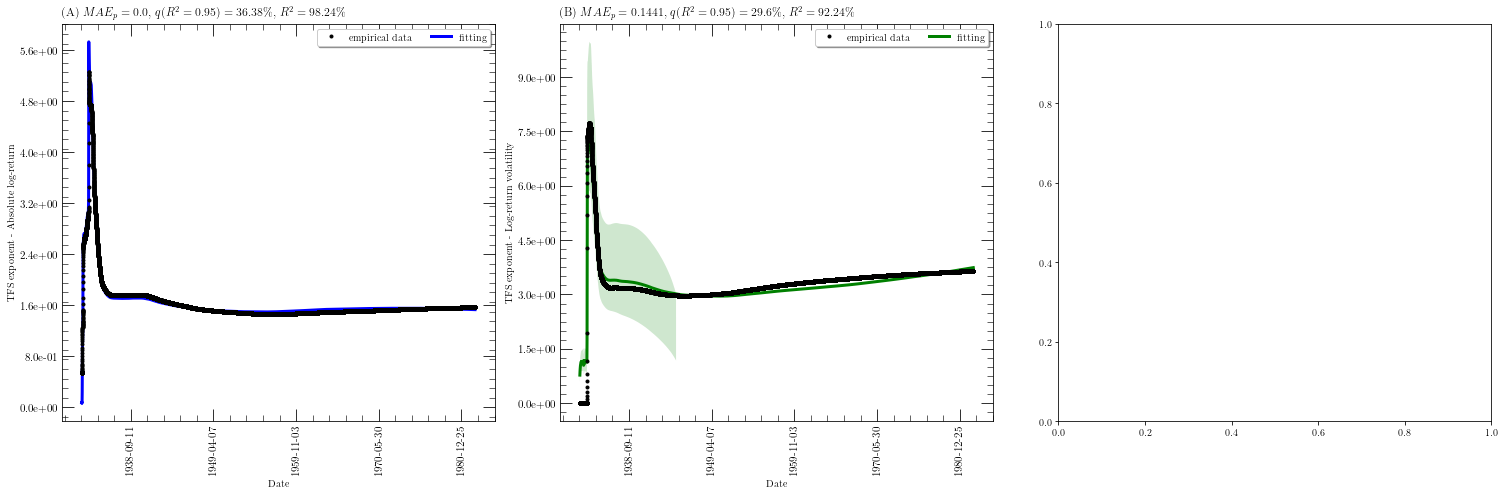

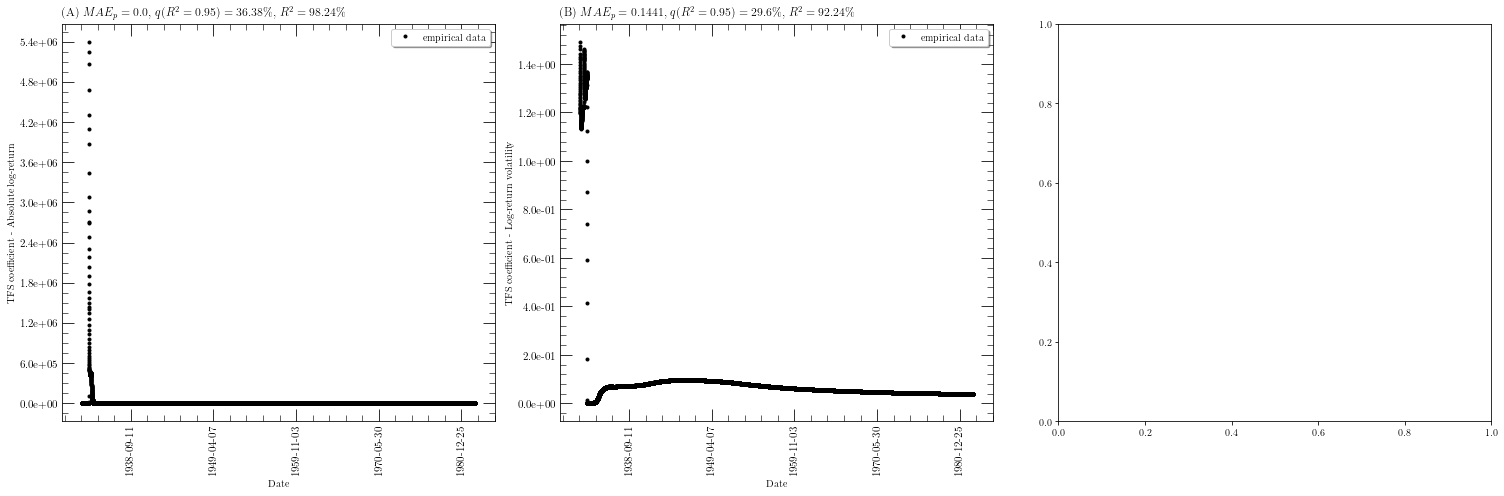

Generated plot for ^DJI and time series absolute log-return
Generated plot for ^DJI and time series log-return volatility


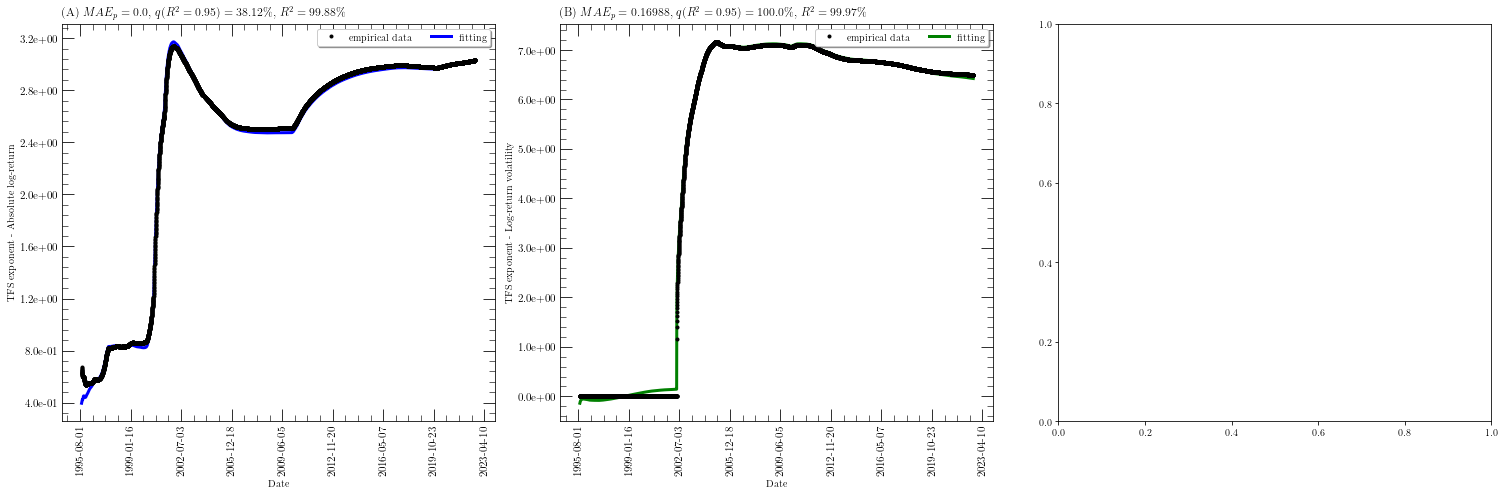

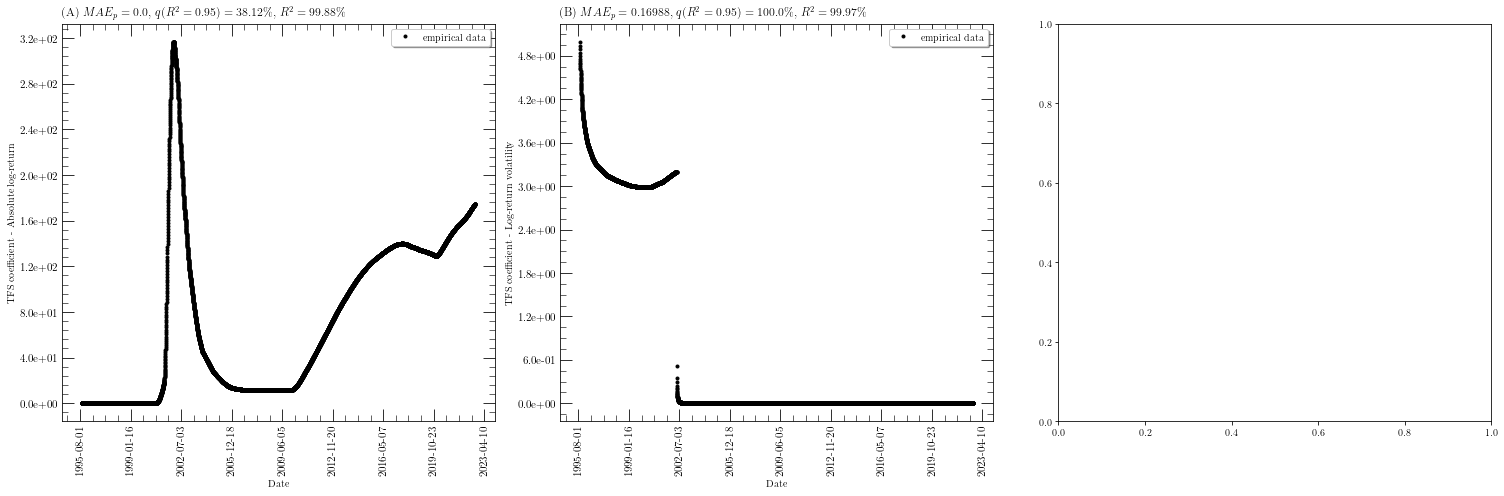

Generated plot for ^W5000 and time series absolute log-return
Generated plot for ^W5000 and time series log-return
Generated plot for ^W5000 and time series log-return volatility


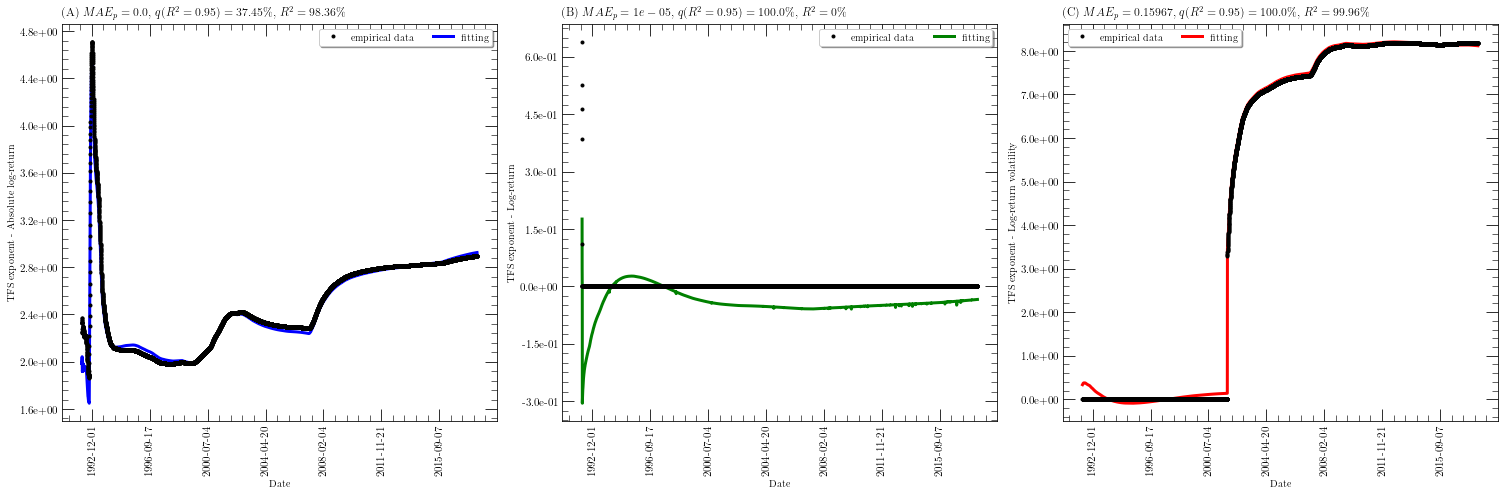

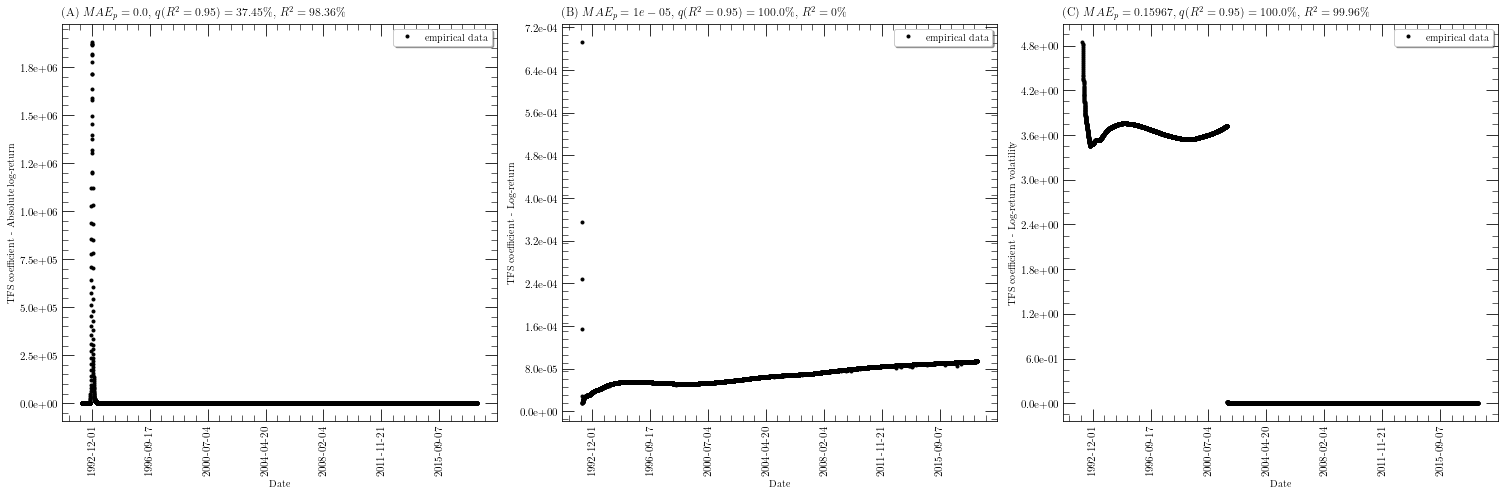

Generated plot for ^GSPTSE and time series absolute log-return
Generated plot for ^GSPTSE and time series log-return volatility


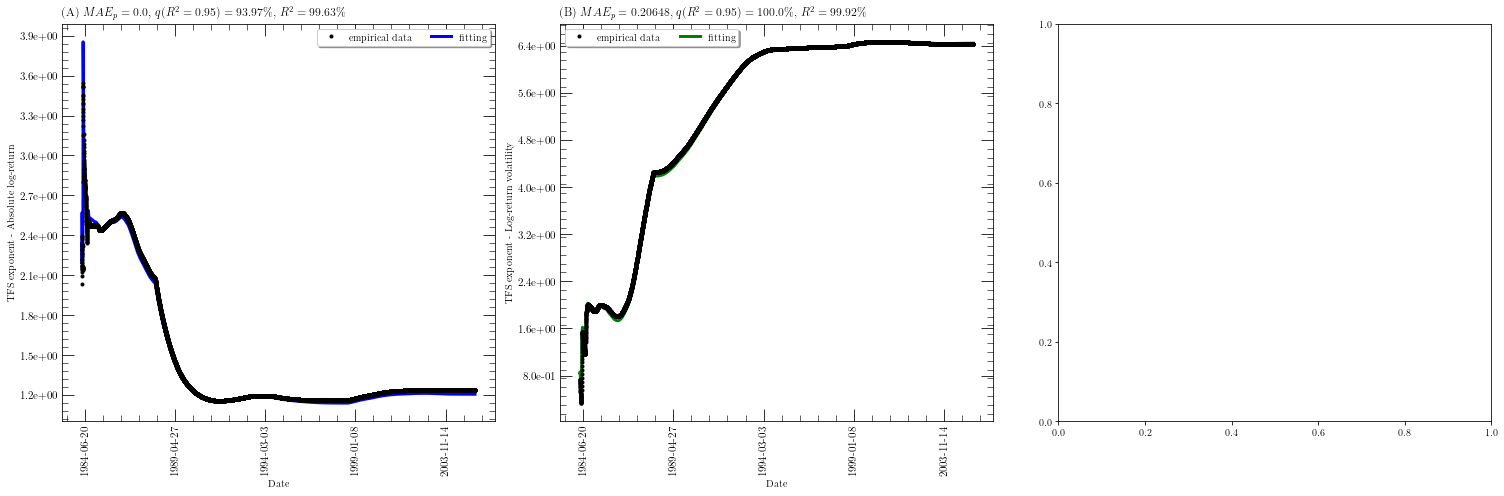

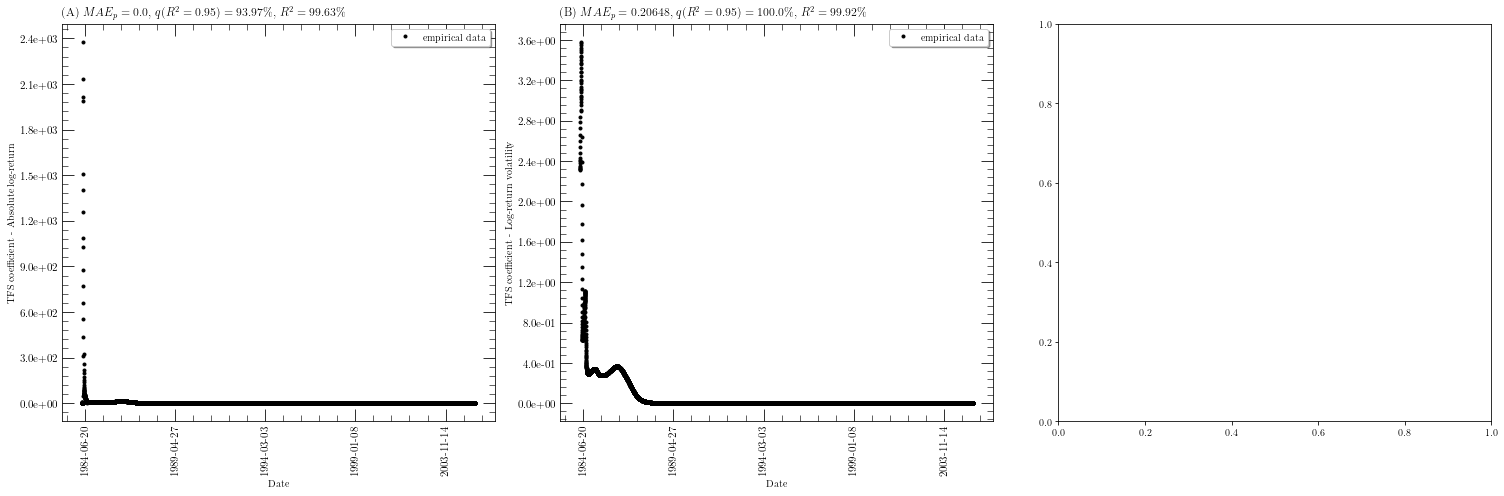

Generated plot for ^GDAXI and time series absolute log-return
Generated plot for ^GDAXI and time series log-return volatility


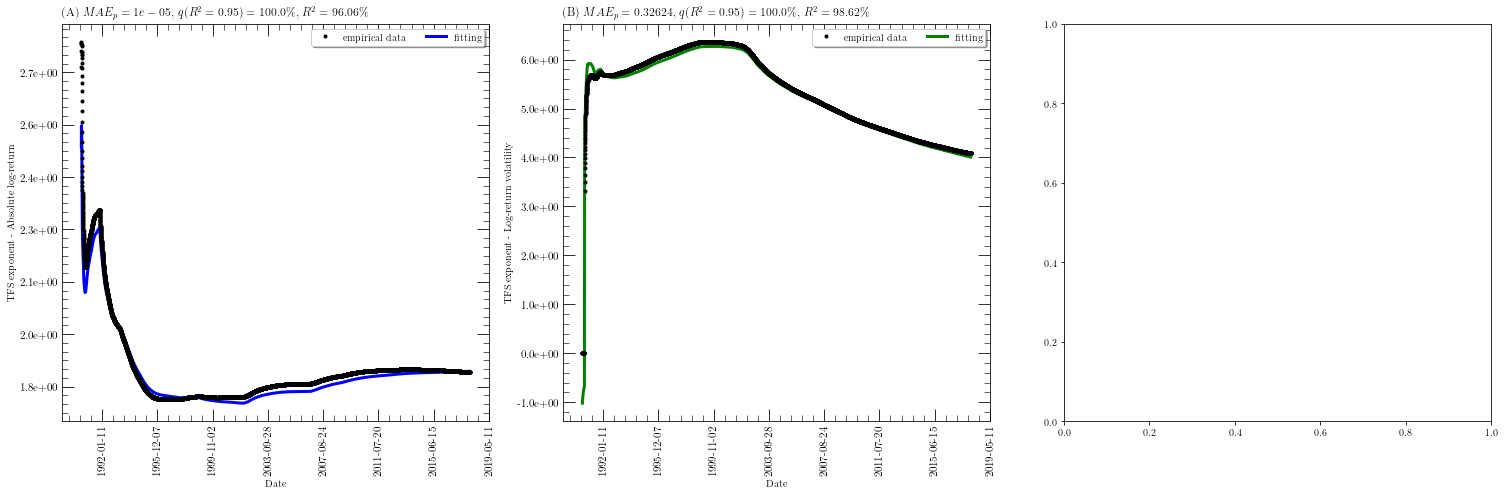

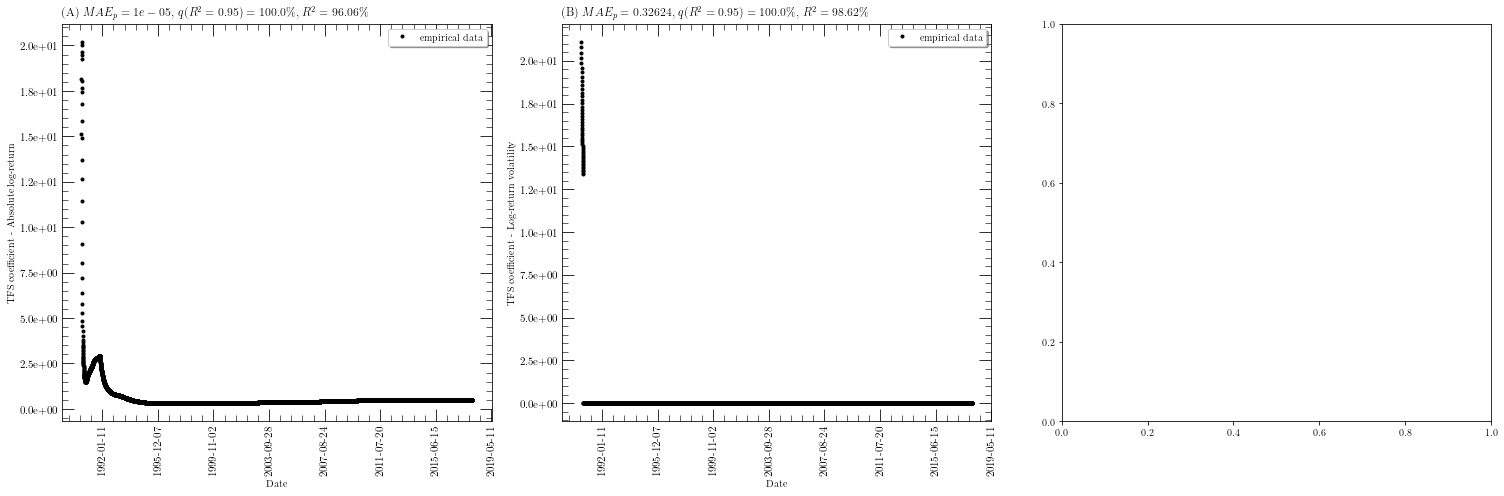

Generated plot for ^FTSE and time series absolute log-return
Generated plot for ^FTSE and time series log-return
Generated plot for ^FTSE and time series log-return volatility


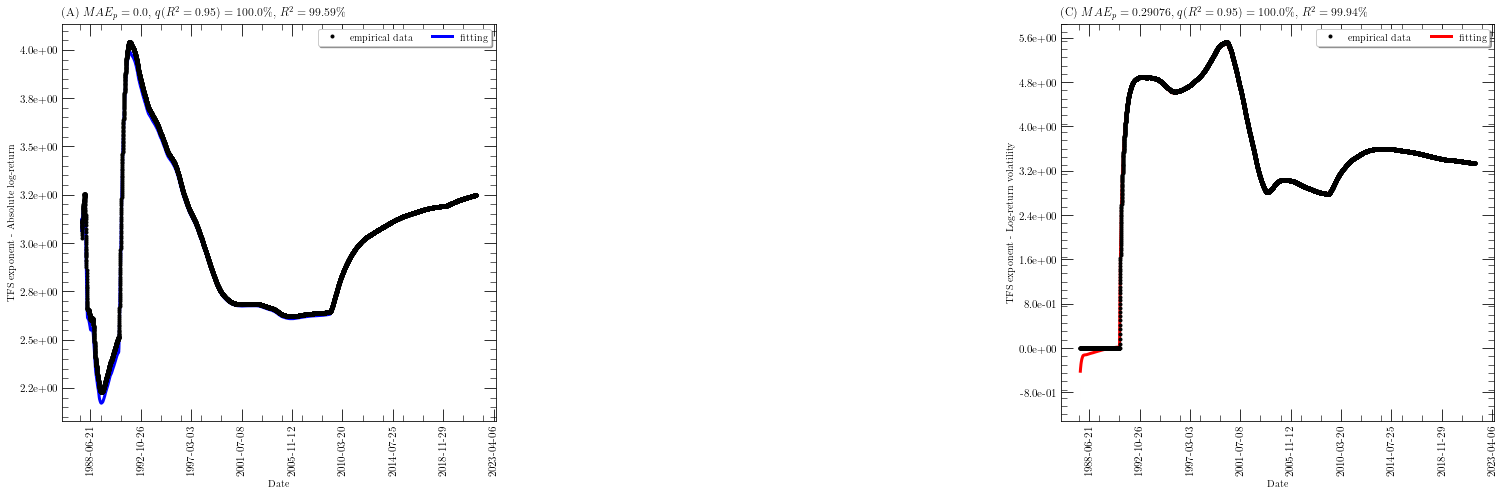

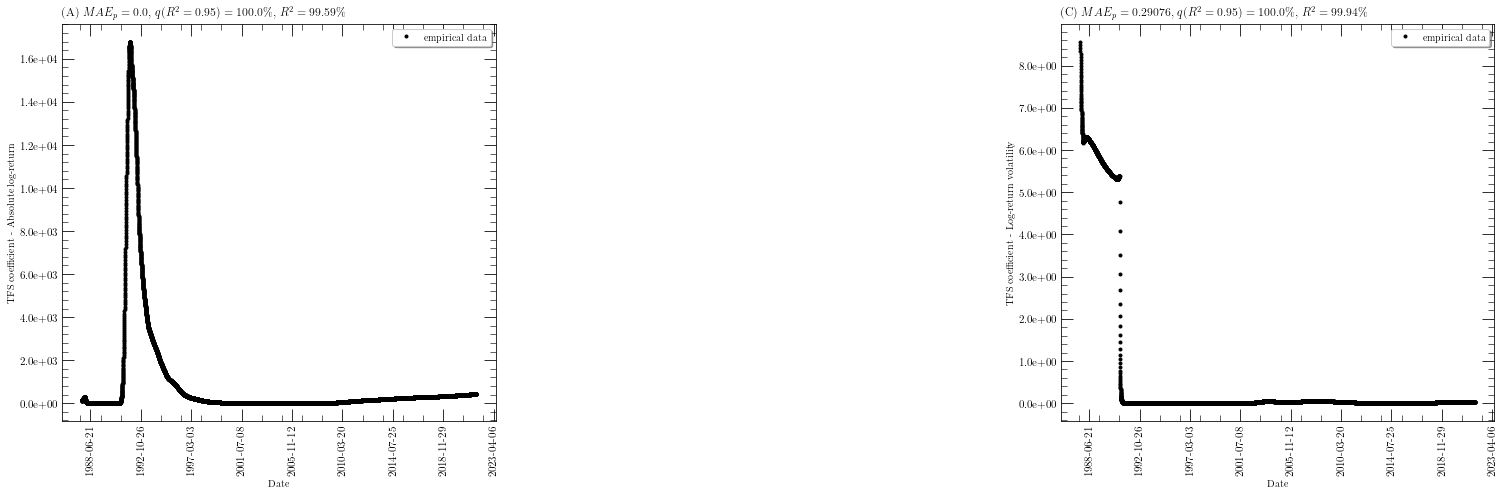

Generated plot for ^FCHI and time series absolute log-return
Generated plot for ^FCHI and time series log-return
Generated plot for ^FCHI and time series log-return volatility


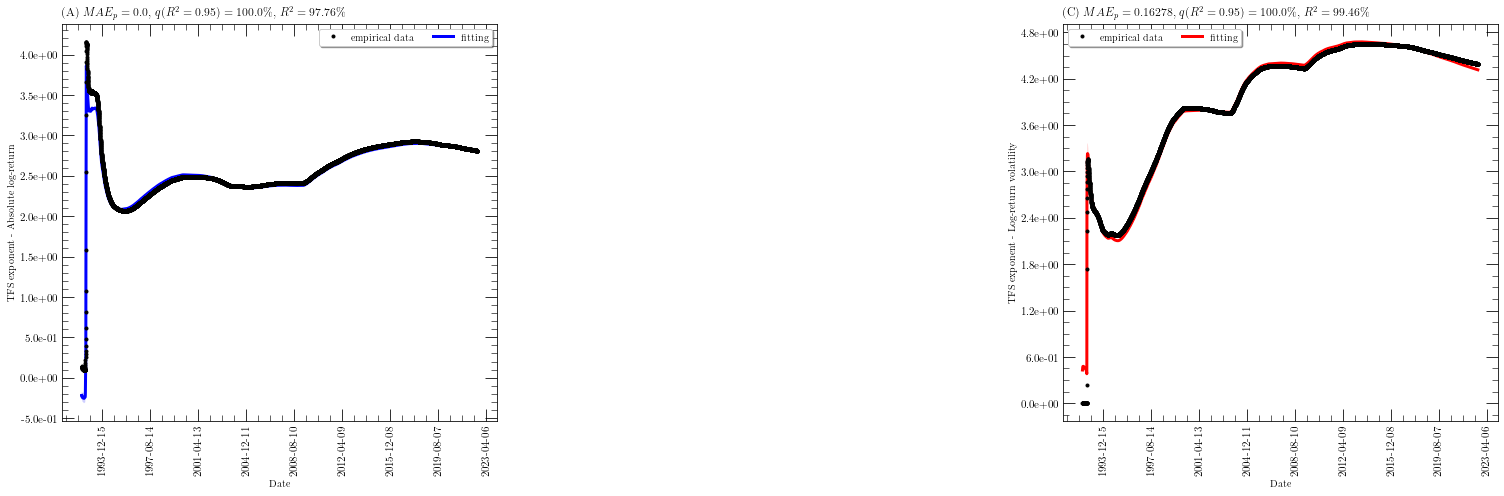

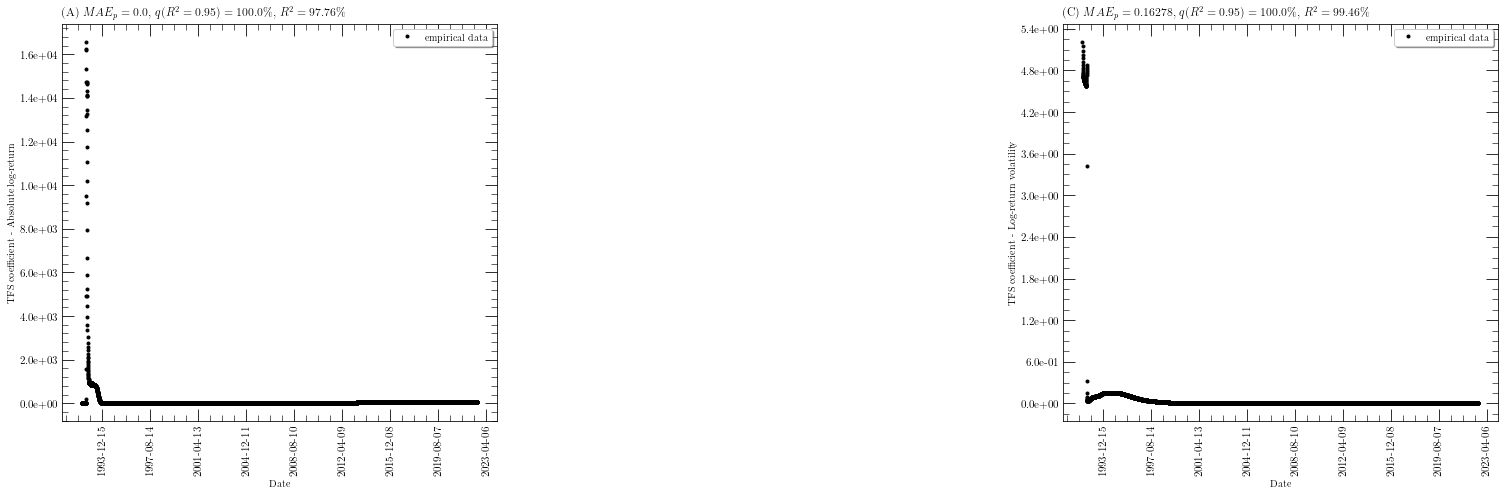

Generated plot for ^IXIC and time series absolute log-return
Generated plot for ^IXIC and time series log-return
Generated plot for ^IXIC and time series log-return volatility


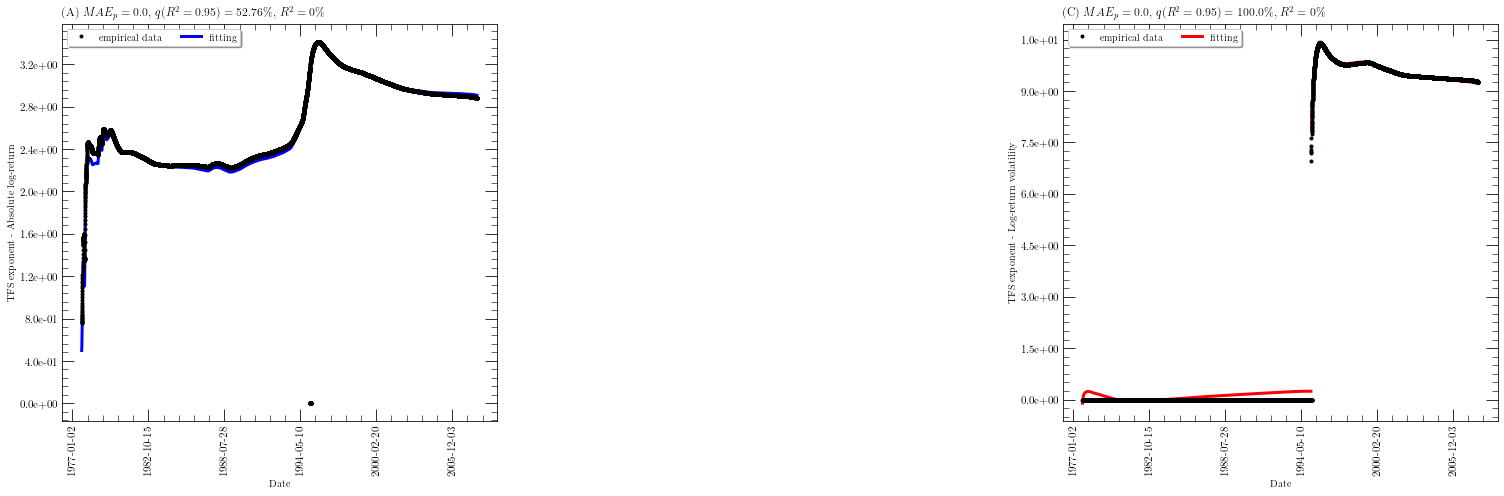

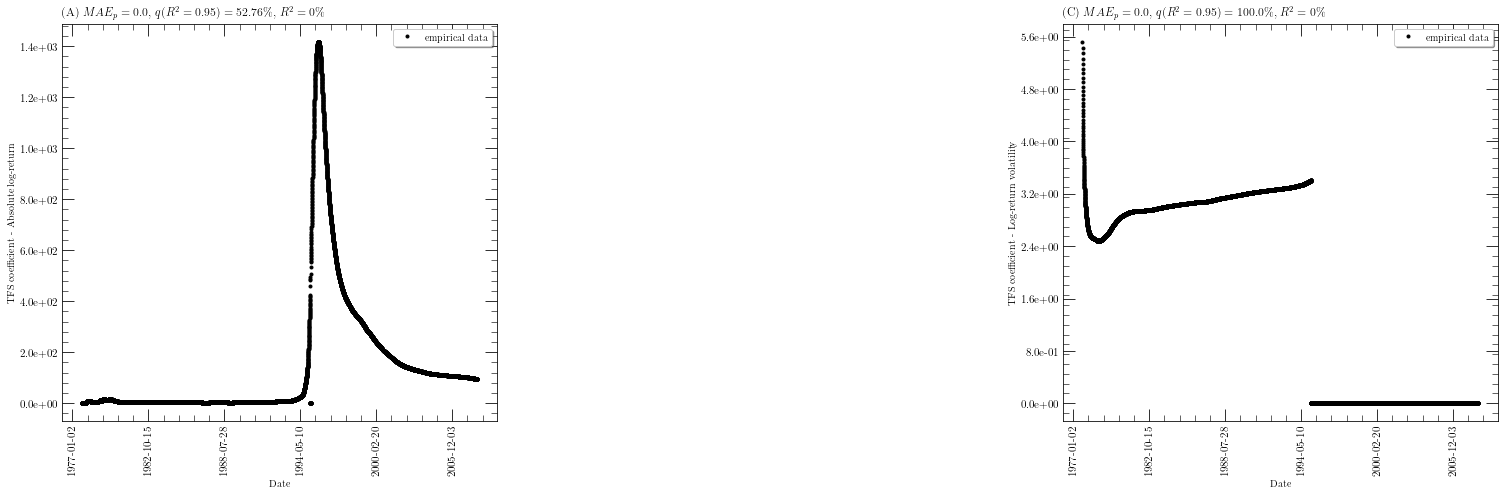

Generated plot for IMOEX.ME and time series absolute log-return
Generated plot for IMOEX.ME and time series log-return volatility


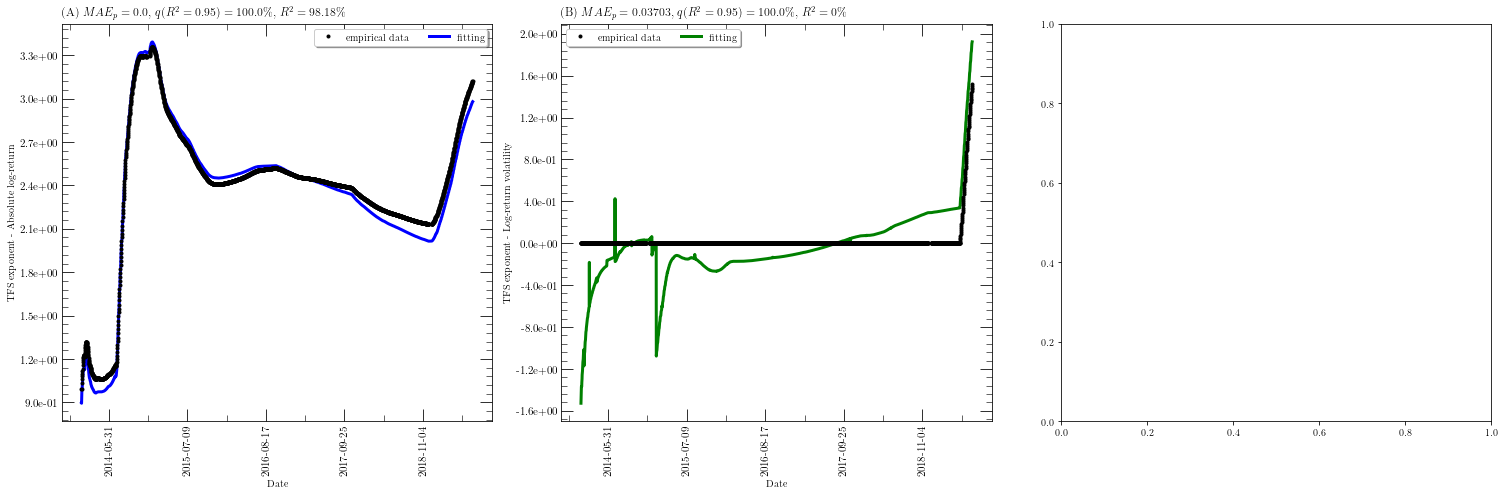

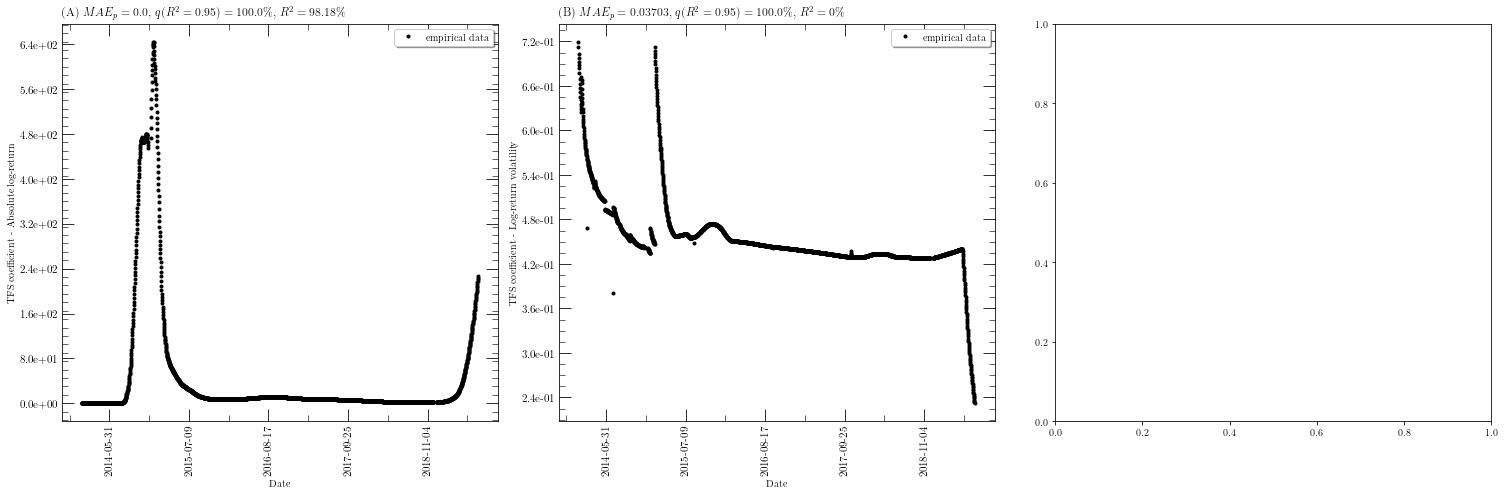

Generated plot for ^N225 and time series absolute log-return
Generated plot for ^N225 and time series log-return volatility


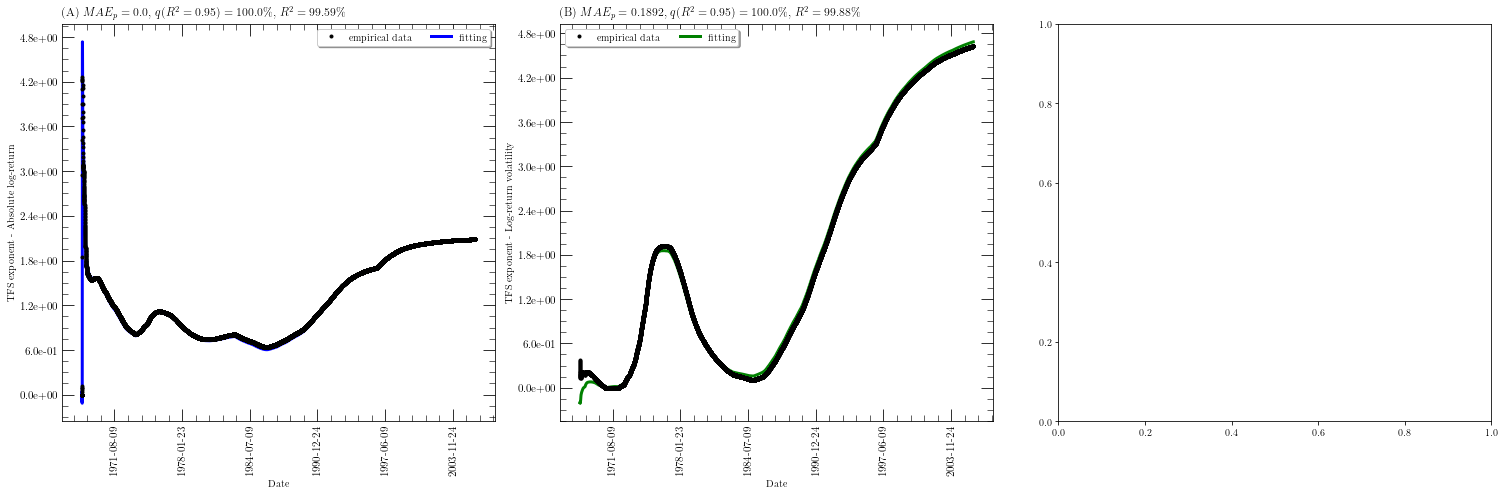

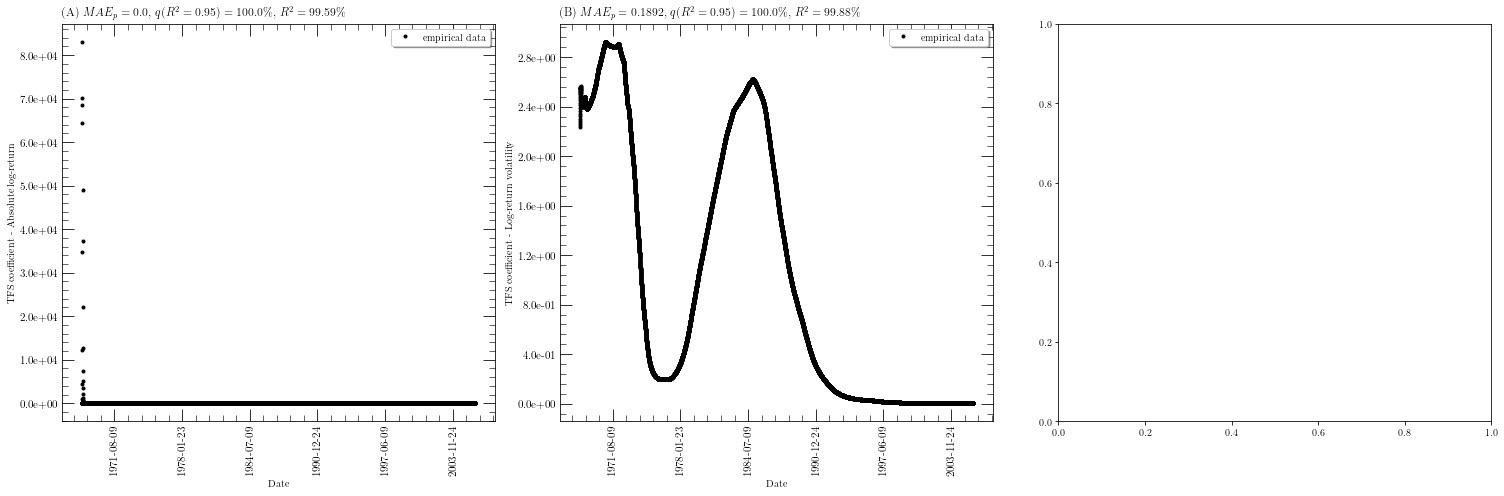

Generated plot for ^STI and time series absolute log-return
Generated plot for ^STI and time series log-return
Generated plot for ^STI and time series log-return volatility


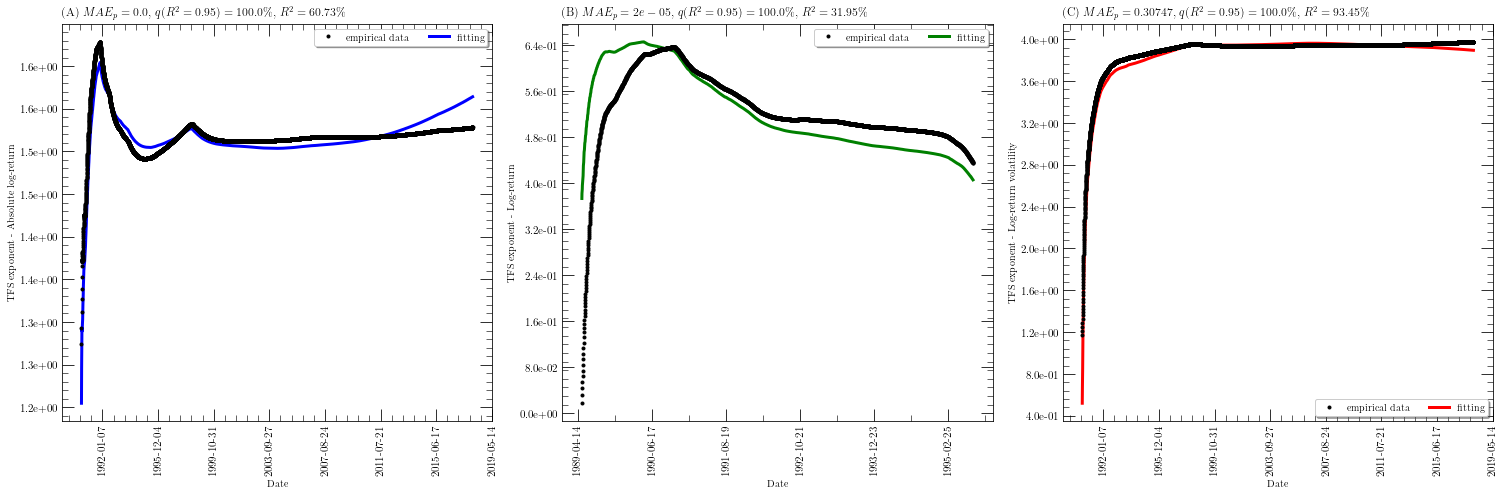

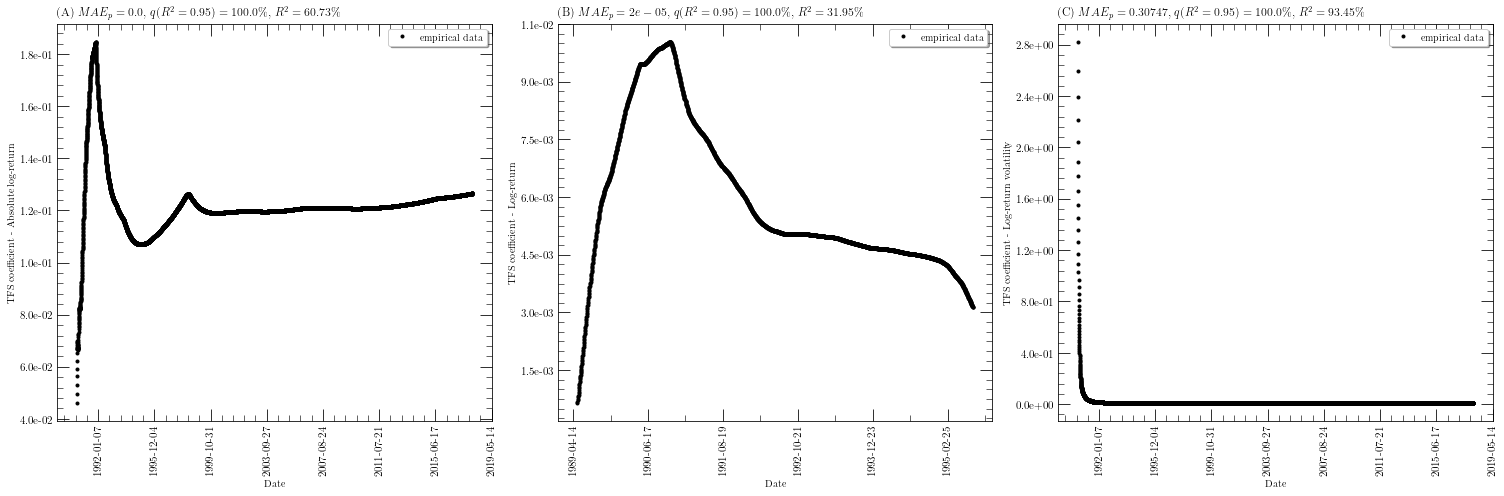

Generated plot for ^BVSP and time series absolute log-return
Generated plot for ^BVSP and time series log-return volatility


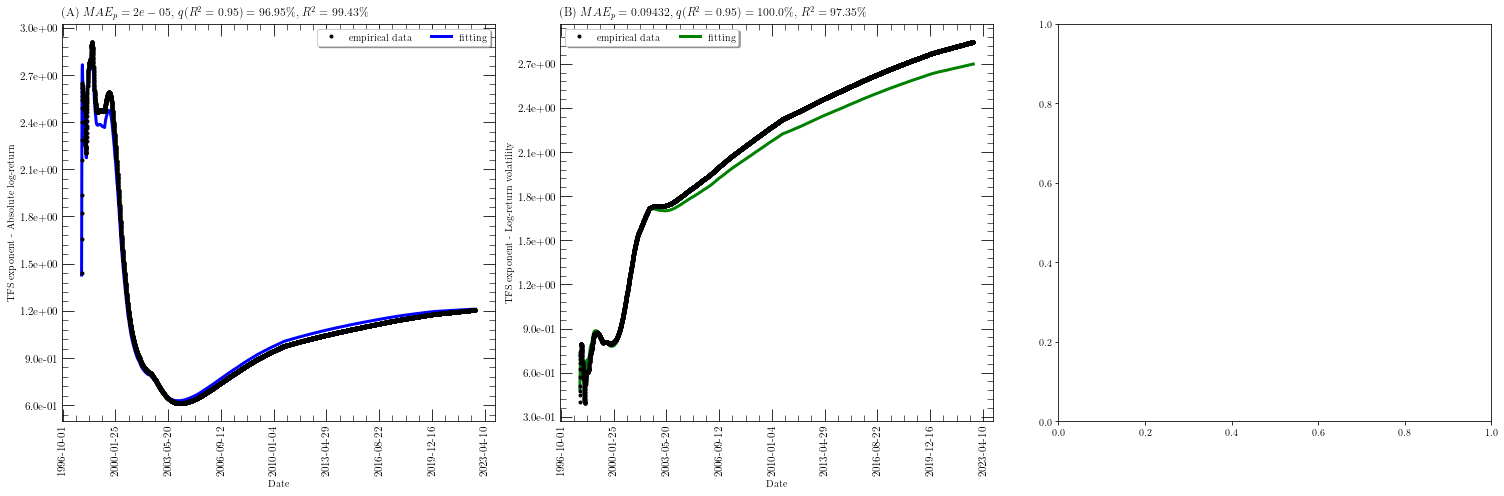

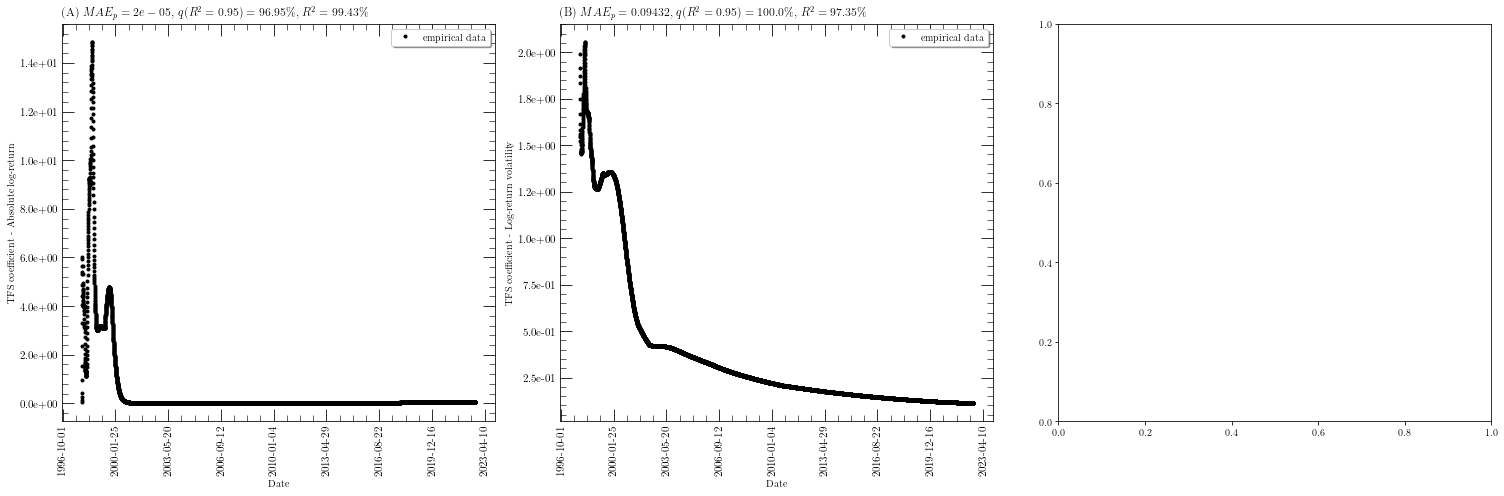

Generated plot for ^MERV and time series absolute log-return
Generated plot for ^MERV and time series log-return volatility


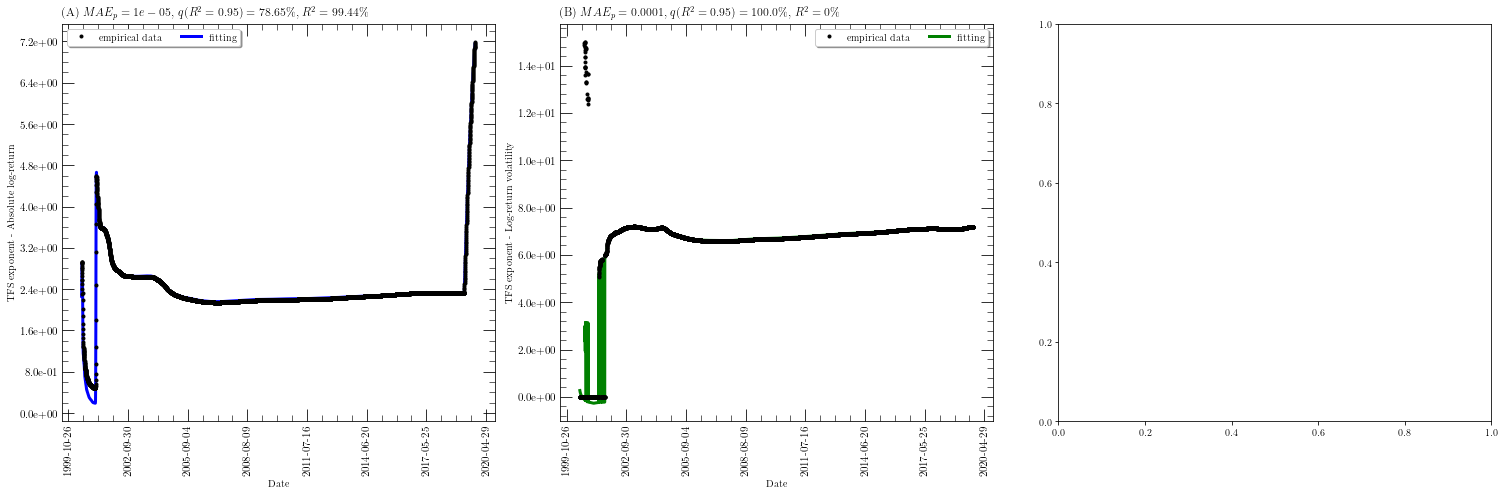

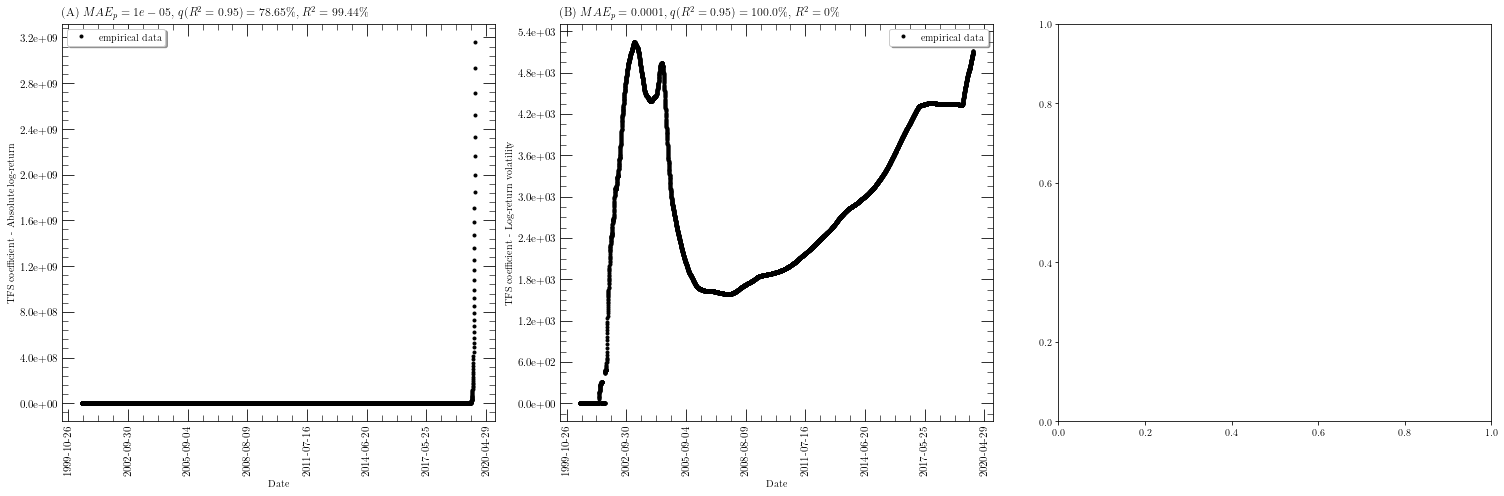

In [9]:
for ticker, ticker_name in list_stock_indexes.items():
    df_graph = plt_tfs.plot_tfs_evolution(
        df_fts = df_stock_indexes,
        df_optimal = df_optimal_stock_indexes,
        df_tfs = df_stock_indexes_tfs_parameters,
        interval = "days",
        threshold = 0.95,
        symbols = [ticker],
        width = 21,
        height = 7,
        all_data = True,
        markersize = 3,
        fontsize_labels = 11,
        fontsize_legend = 10,
        usetex = True,
        n_cols = 4,
        n_x_breaks = 10,
        n_y_breaks = 10,
        fancy_legend = True,
        dpi = 200,
        save_figures = True,
        output_path = "{}/{}/stock_index".format(output_path, re.sub("-", "", input_generation_date)),
        information_name = re.sub("(\^)|(=X)", "", ticker),
        input_generation_date = input_generation_date
    )

Generated plot for KWDUSD=X and time series absolute log-return
Generated plot for KWDUSD=X and time series log-return volatility


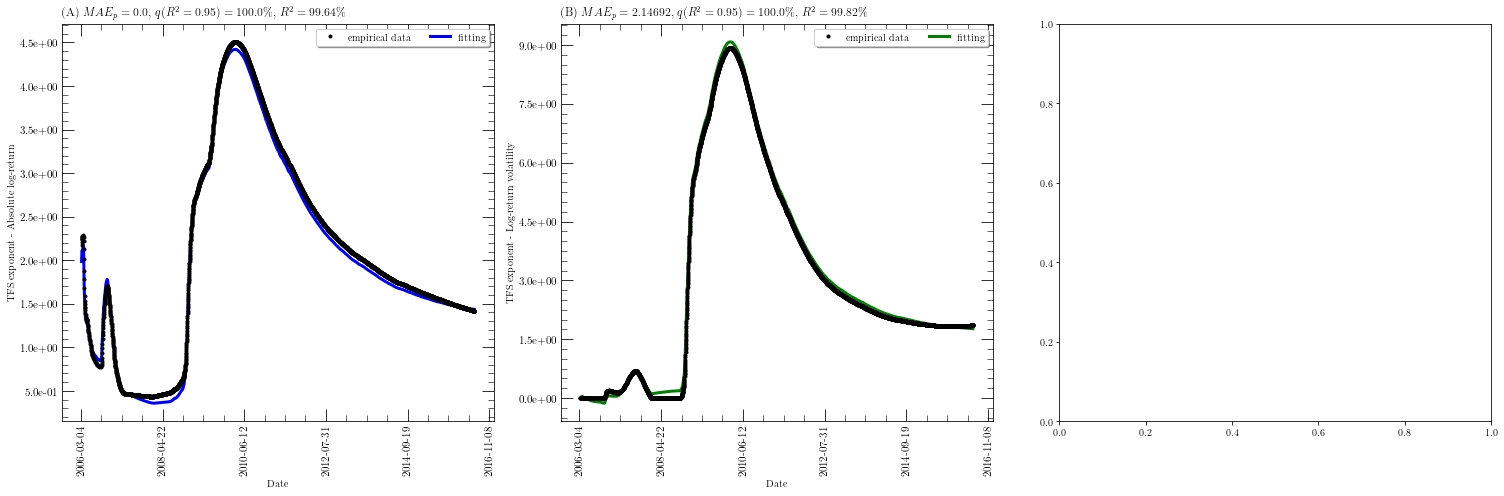

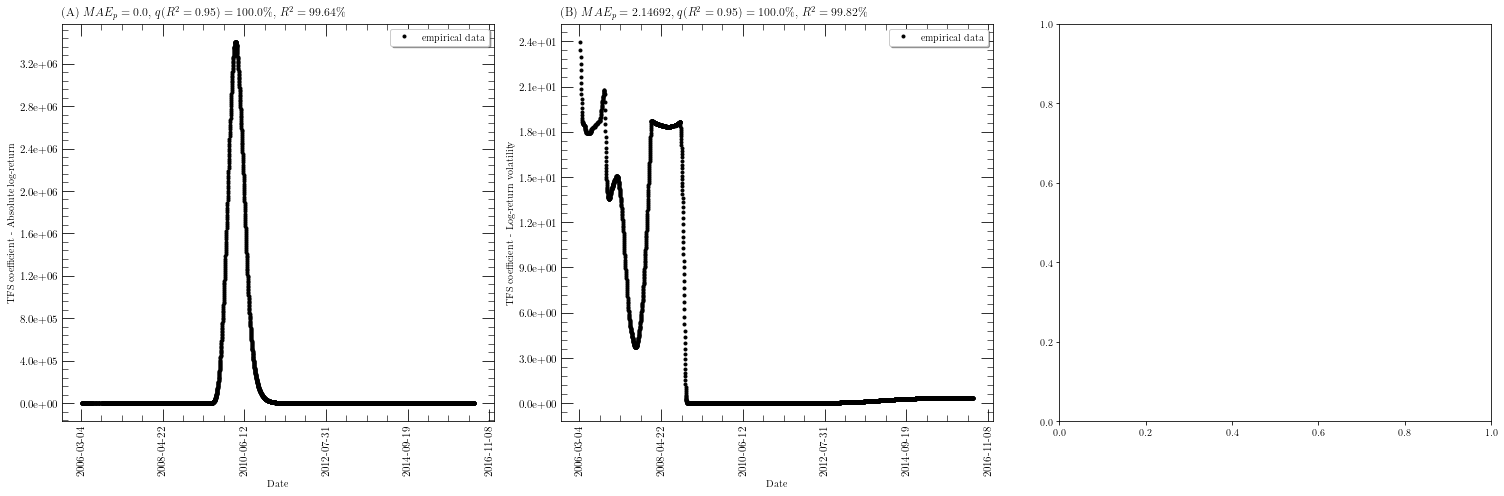

Generated plot for BHDUSD=X and time series absolute log-return
Generated plot for BHDUSD=X and time series log-return
Generated plot for BHDUSD=X and time series log-return volatility


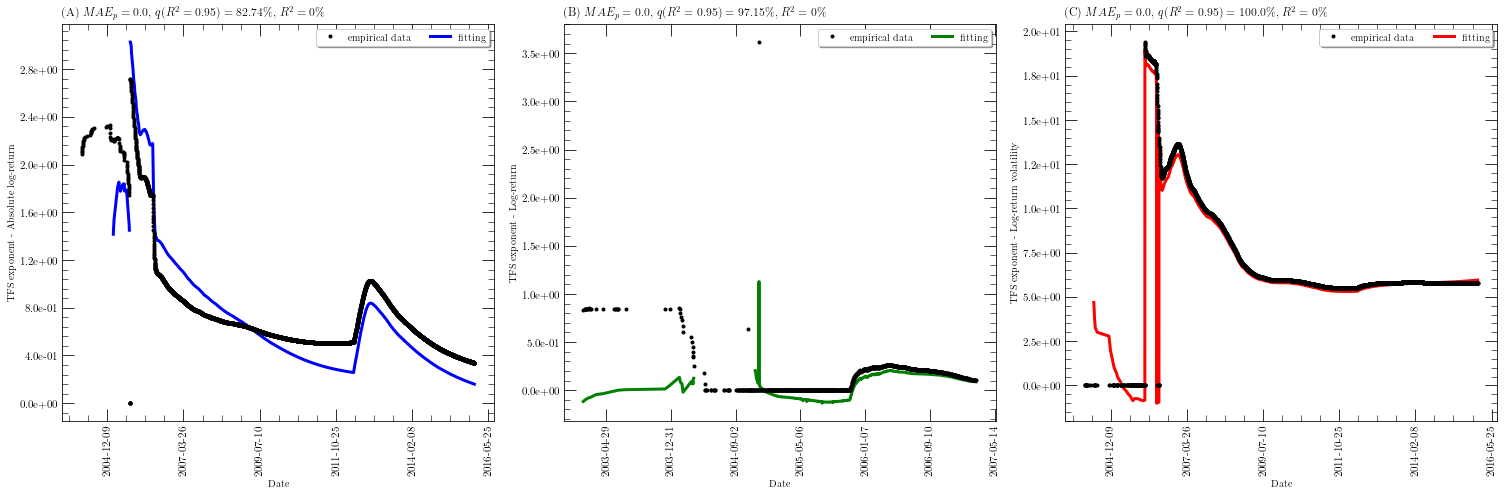

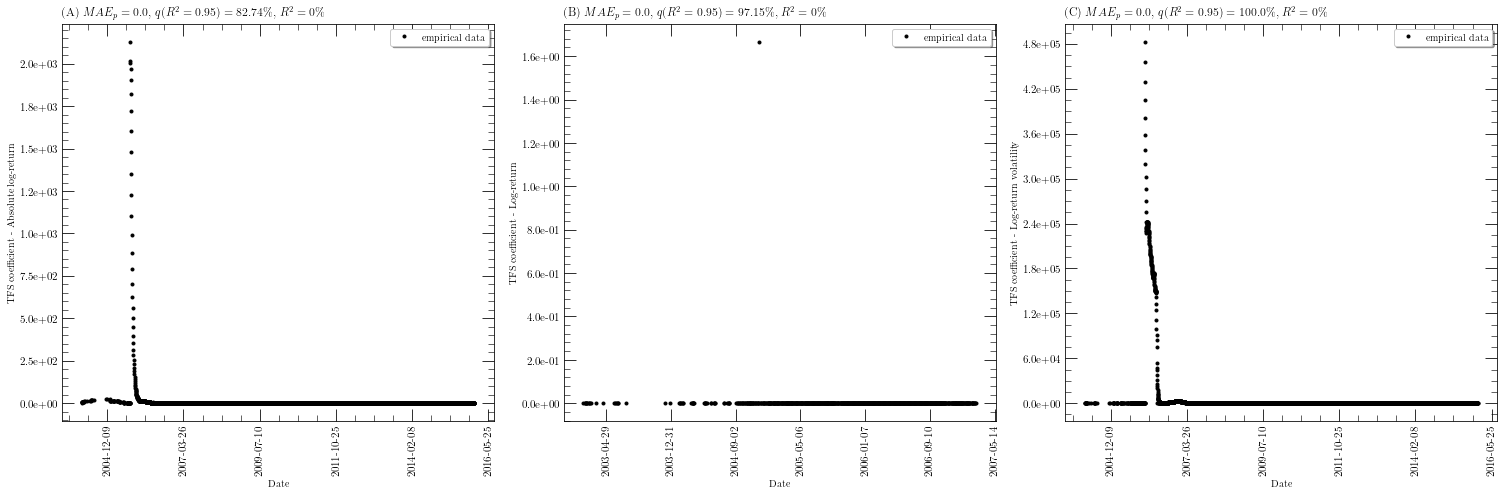

Generated plot for OMRUSD=X and time series absolute log-return
Generated plot for OMRUSD=X and time series log-return
Generated plot for OMRUSD=X and time series log-return volatility


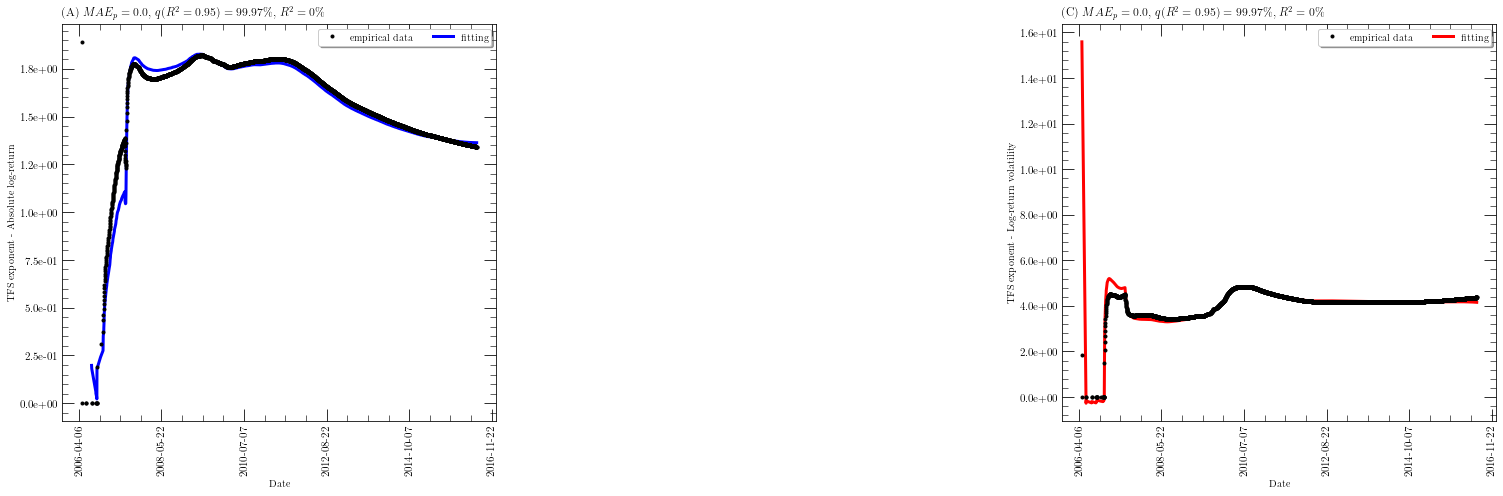

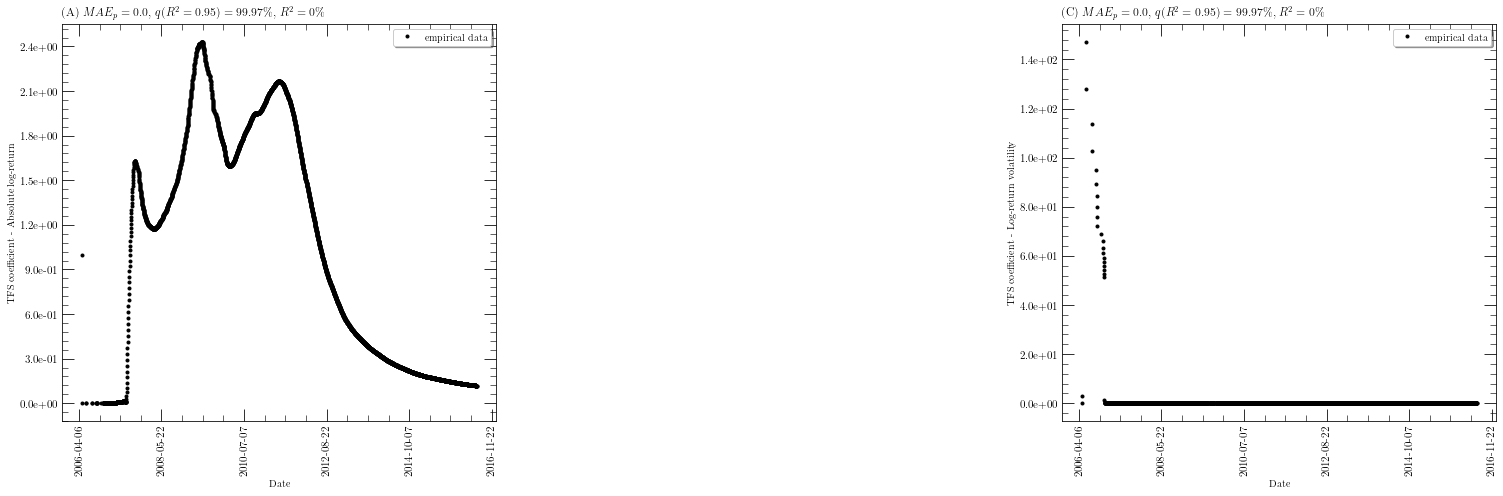

Generated plot for JODUSD=X and time series absolute log-return
Generated plot for JODUSD=X and time series log-return volatility


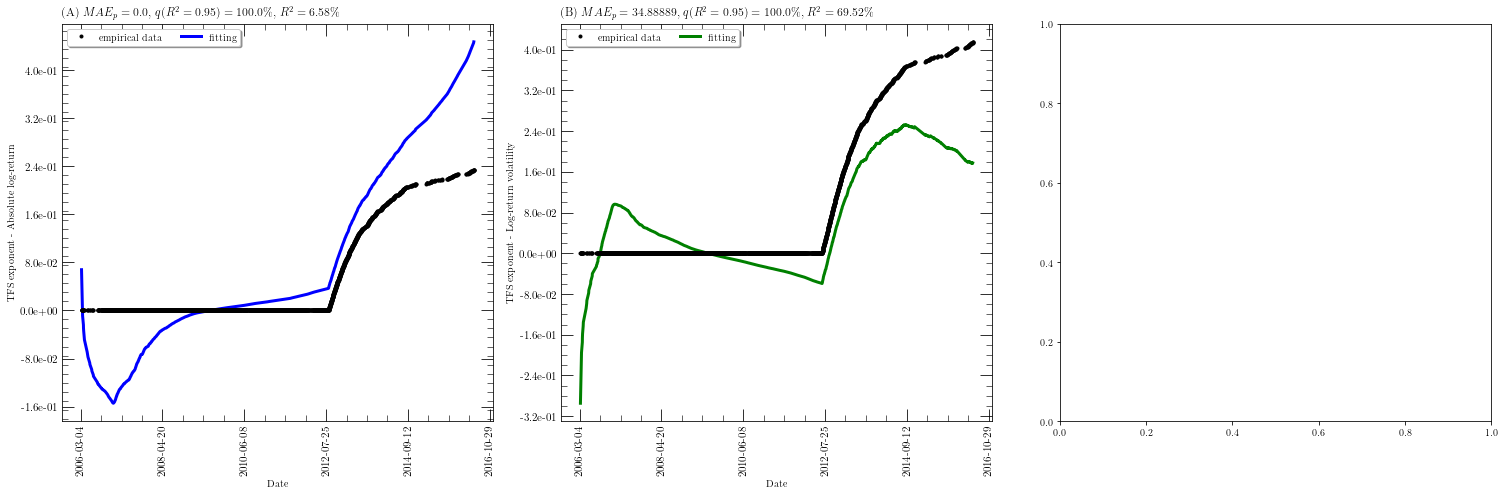

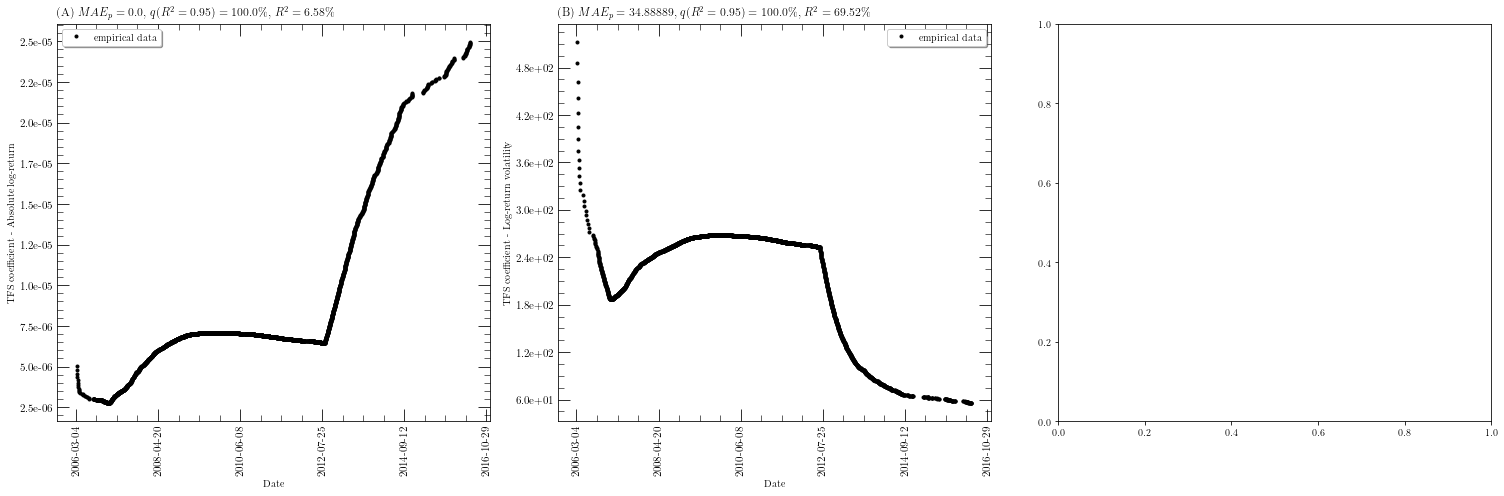

Generated plot for KYDUSD=X and time series absolute log-return
Generated plot for KYDUSD=X and time series log-return
Generated plot for KYDUSD=X and time series log-return volatility


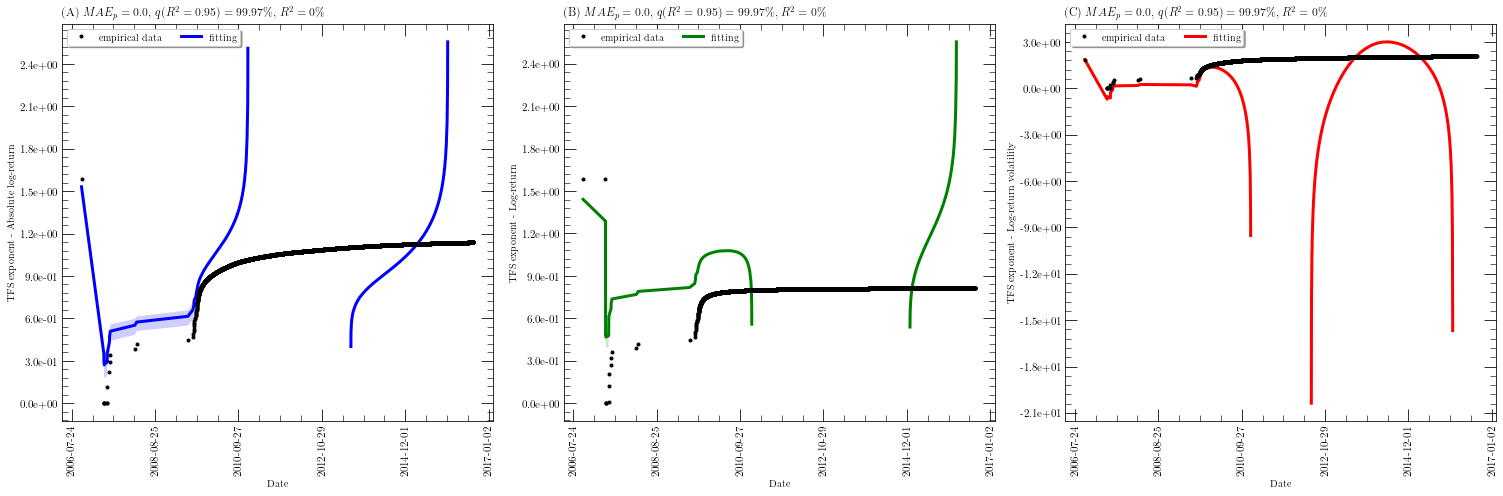

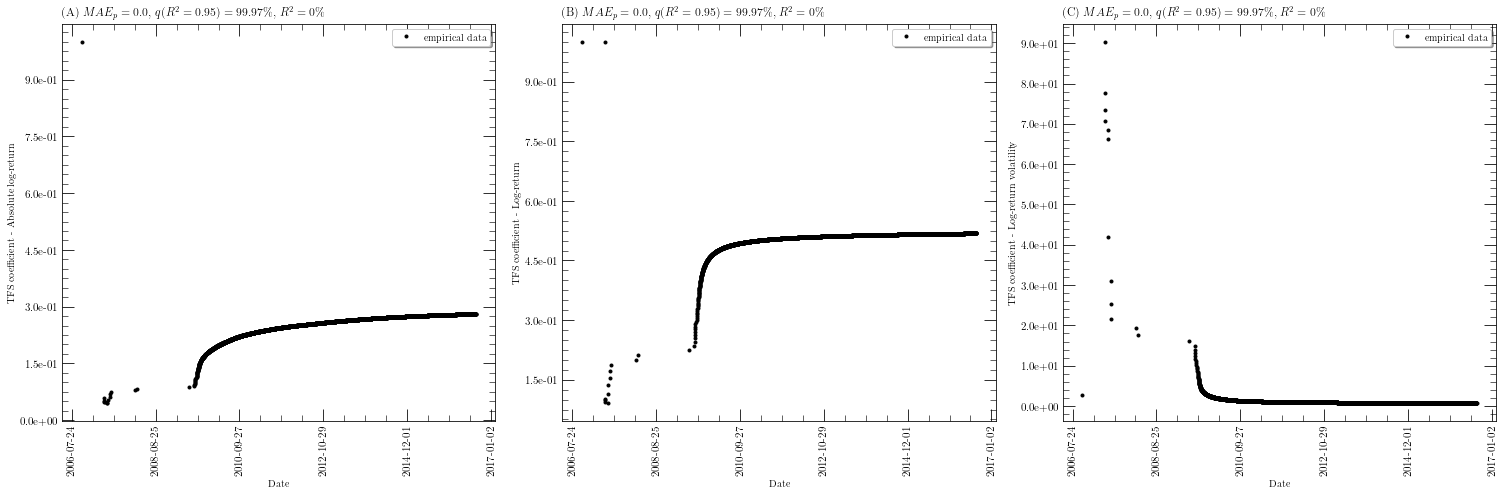

Generated plot for GBPUSD=X and time series absolute log-return
Generated plot for GBPUSD=X and time series log-return volatility


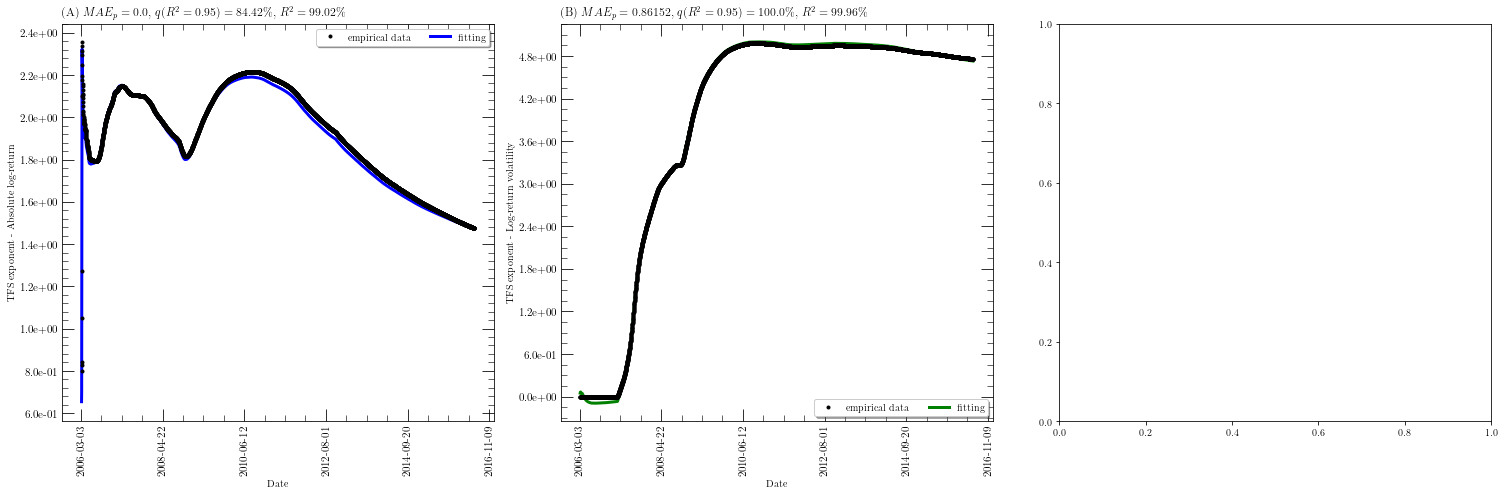

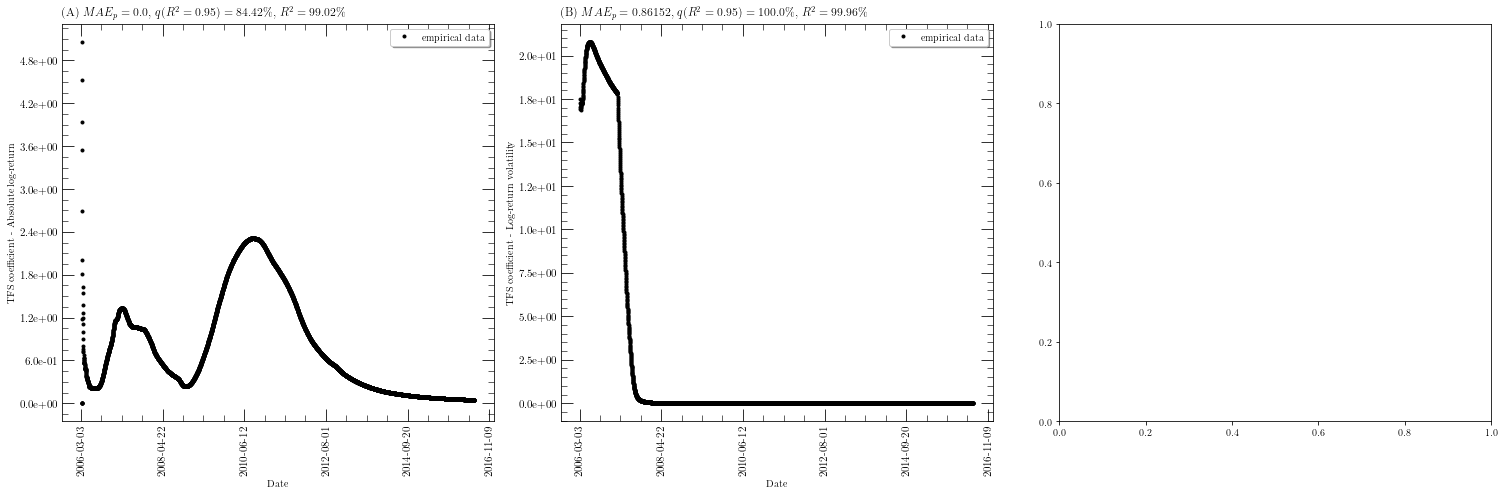

Generated plot for CHFUSD=X and time series absolute log-return
Generated plot for CHFUSD=X and time series log-return
Generated plot for CHFUSD=X and time series log-return volatility


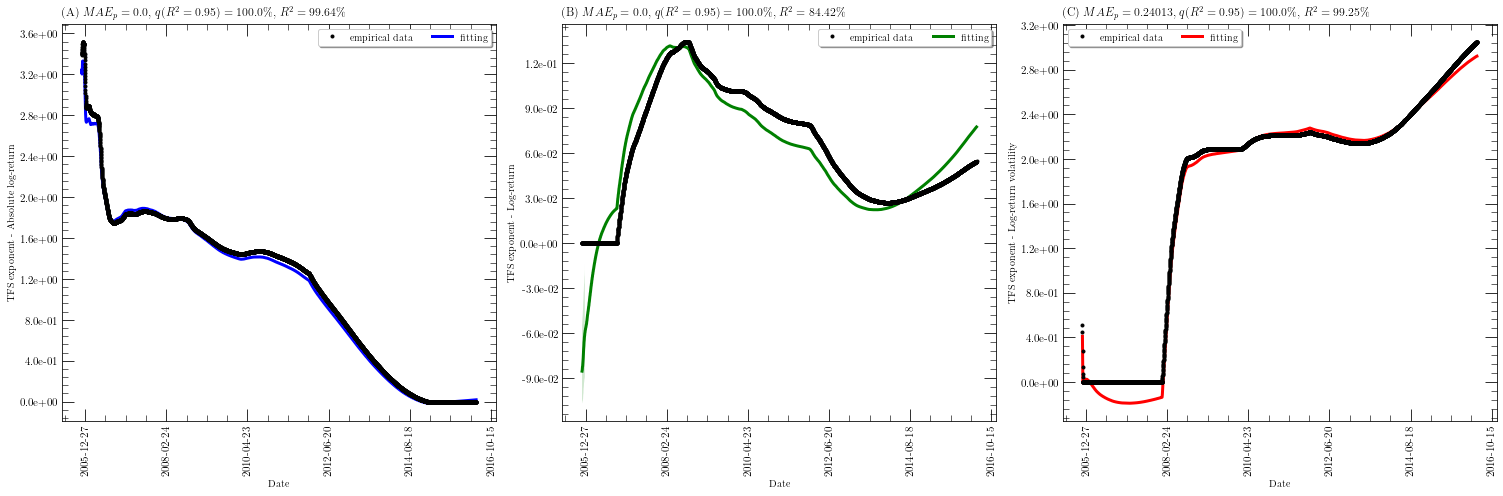

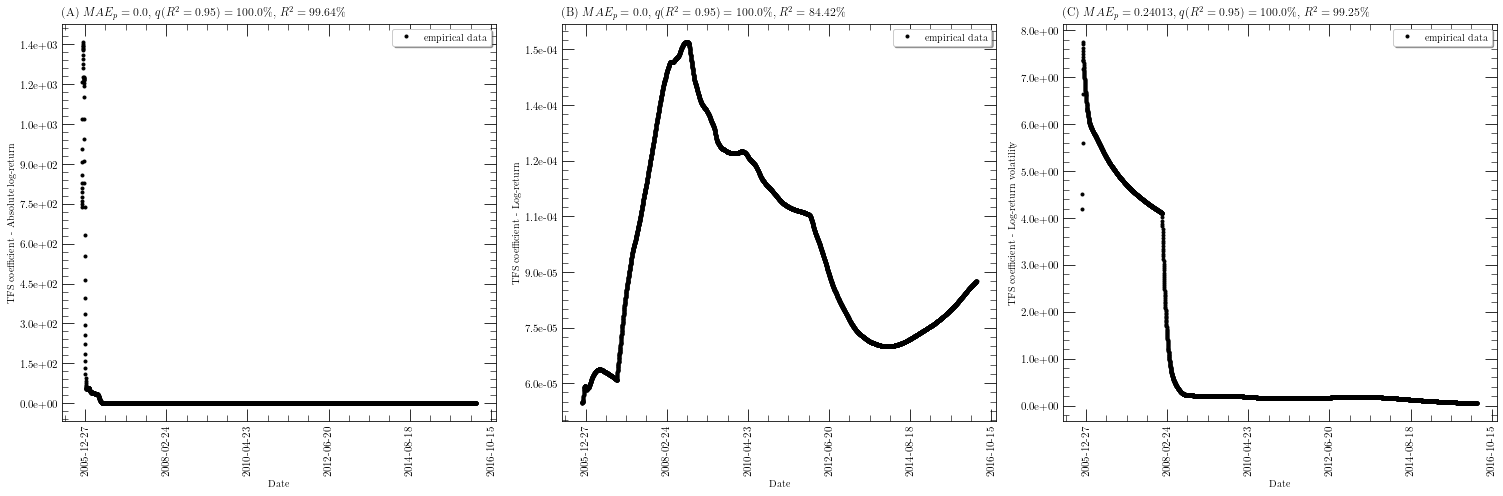

Generated plot for EURUSD=X and time series absolute log-return
Generated plot for EURUSD=X and time series log-return volatility


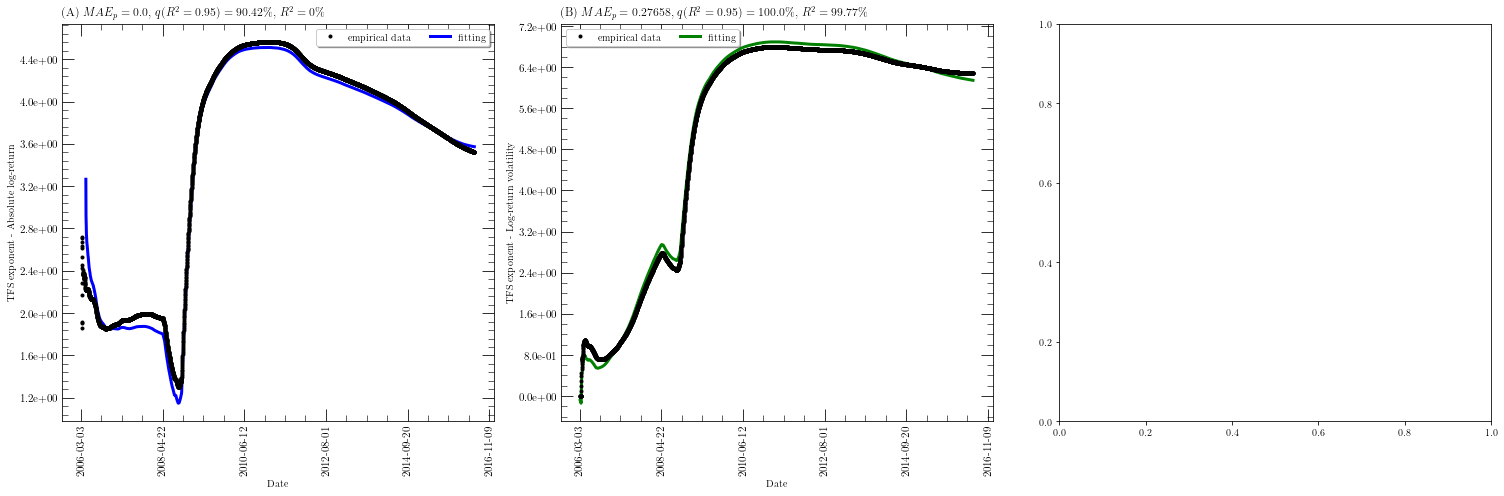

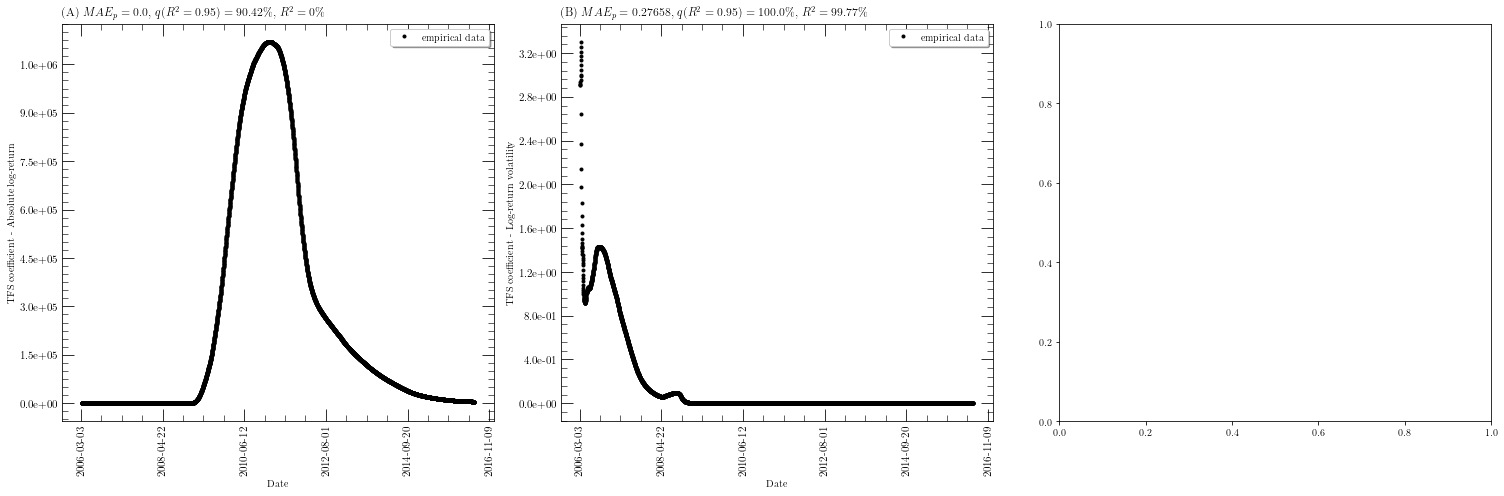

Generated plot for SGD=X and time series absolute log-return
Generated plot for SGD=X and time series log-return volatility


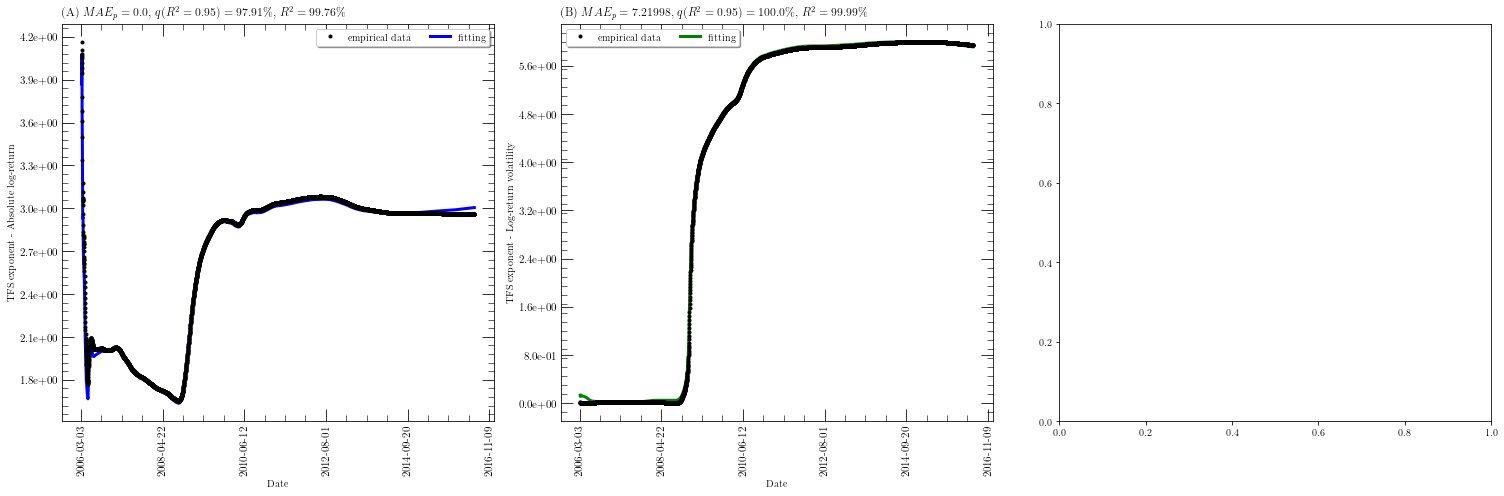

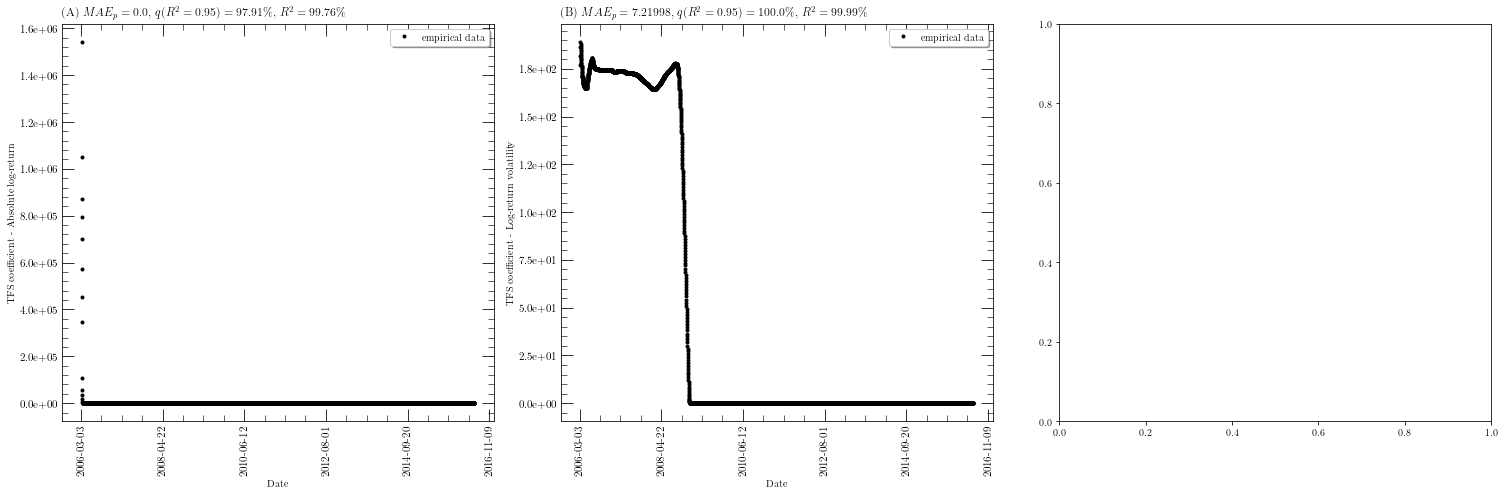

Generated plot for CAD=X and time series absolute log-return
Generated plot for CAD=X and time series log-return volatility


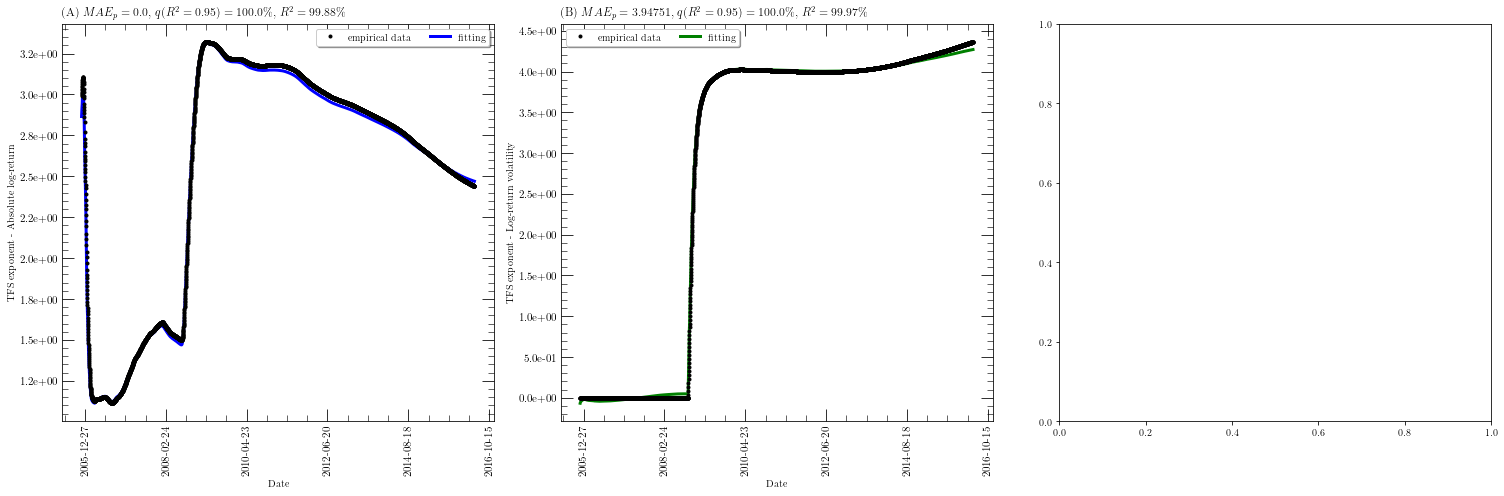

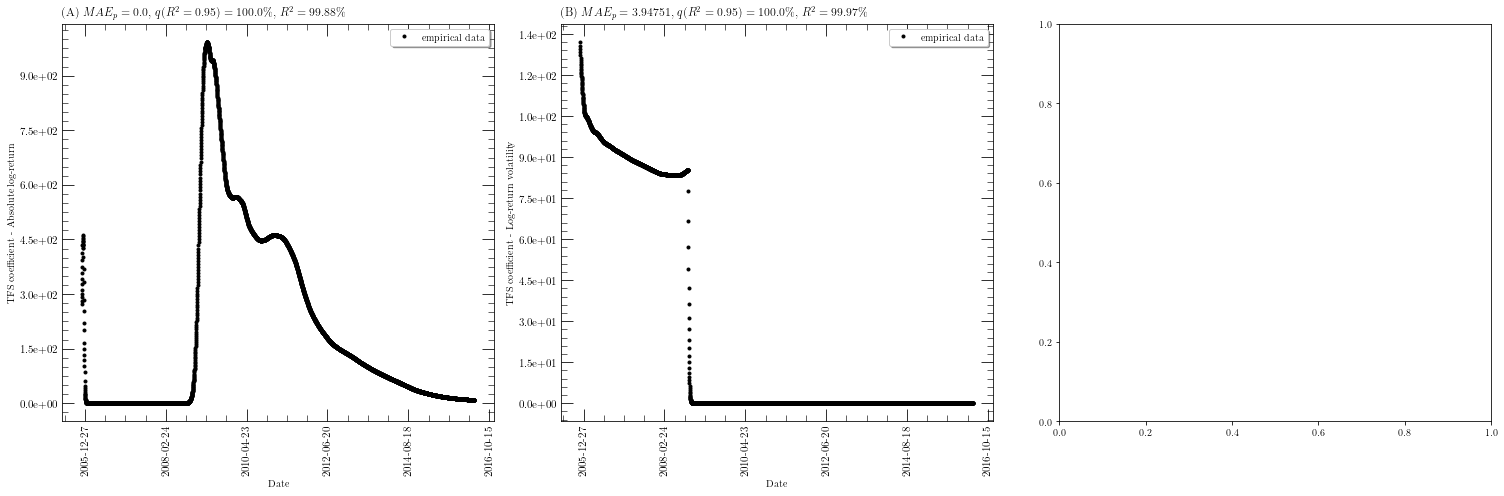

Generated plot for AUD=X and time series absolute log-return
Generated plot for AUD=X and time series log-return
Generated plot for AUD=X and time series log-return volatility


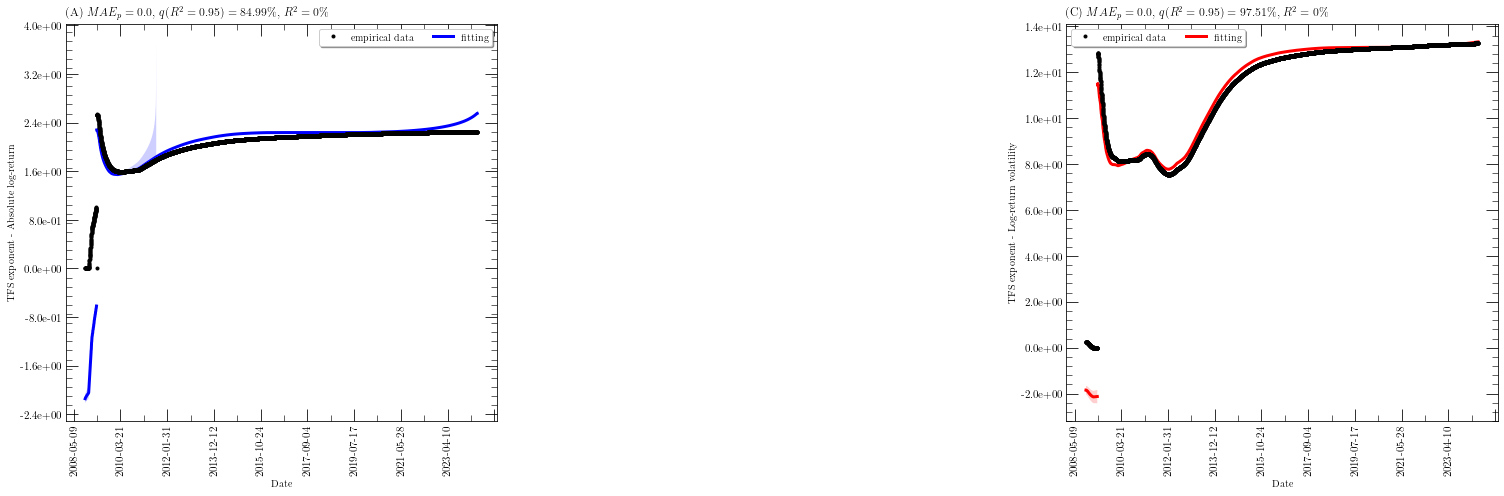

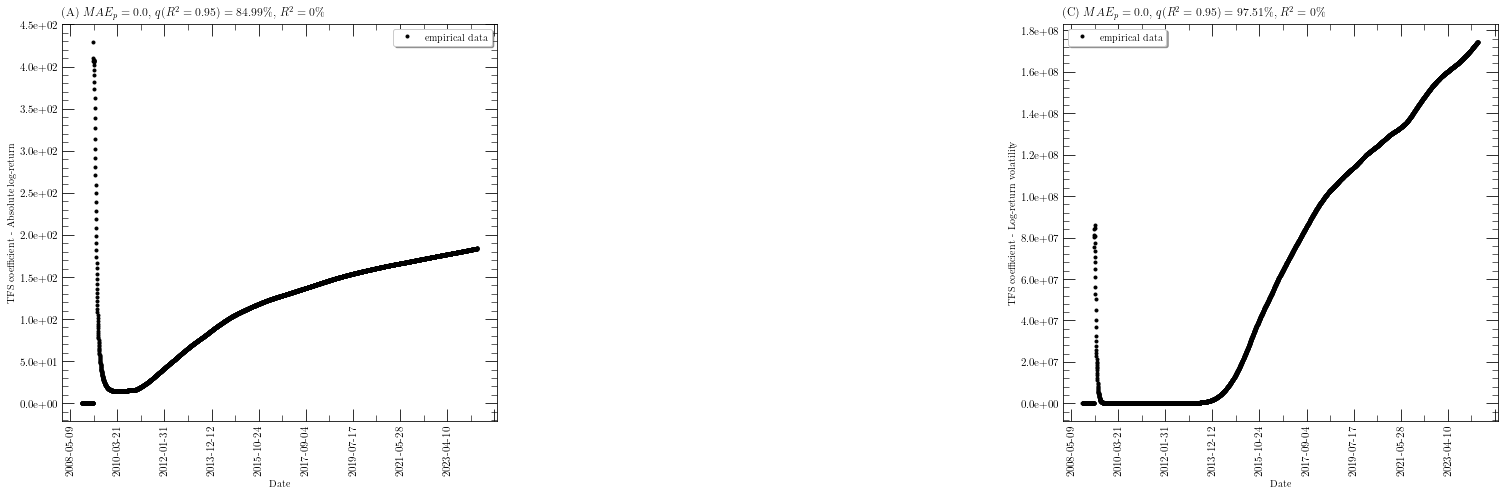

Generated plot for NZD=X and time series absolute log-return
Generated plot for NZD=X and time series log-return volatility


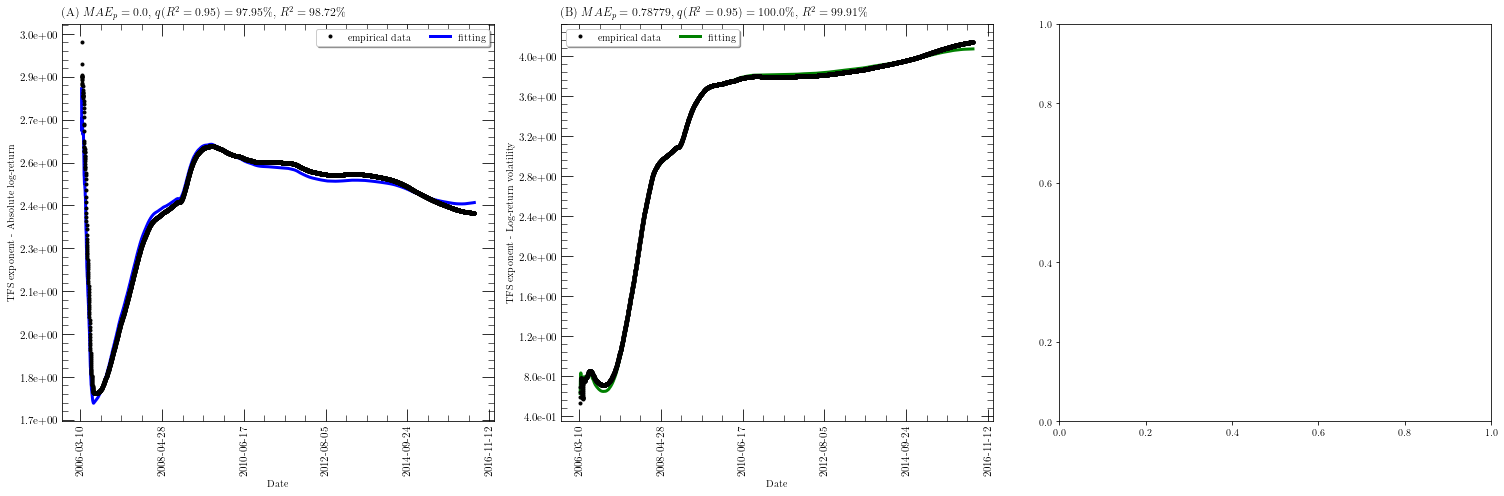

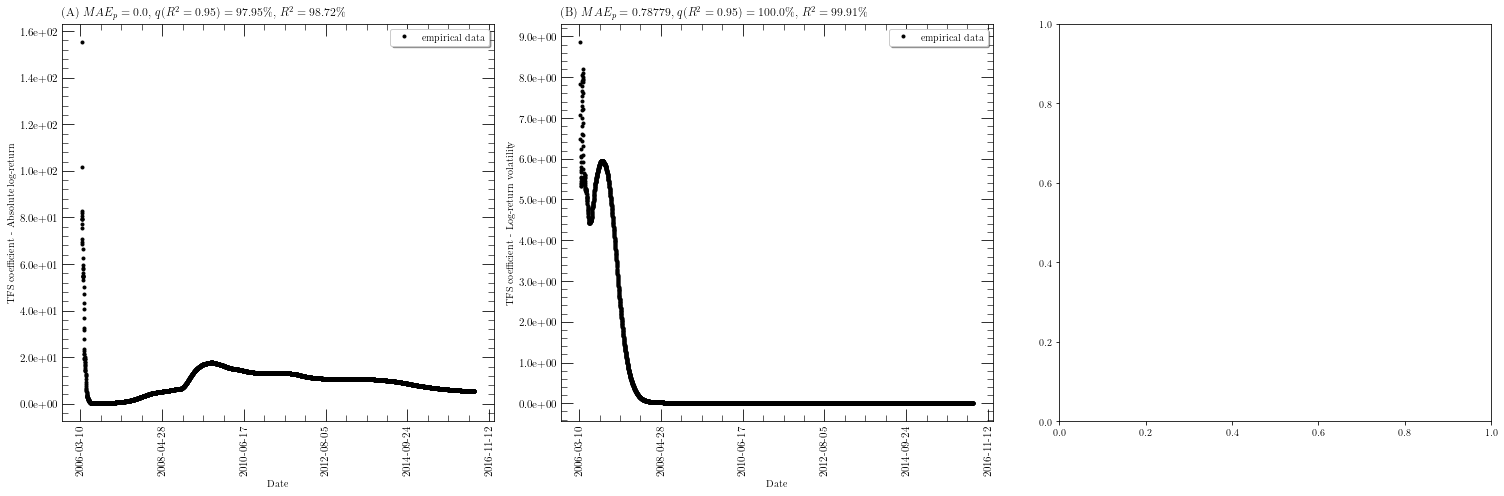

Generated plot for MYR=X and time series absolute log-return
Generated plot for MYR=X and time series log-return
Generated plot for MYR=X and time series log-return volatility


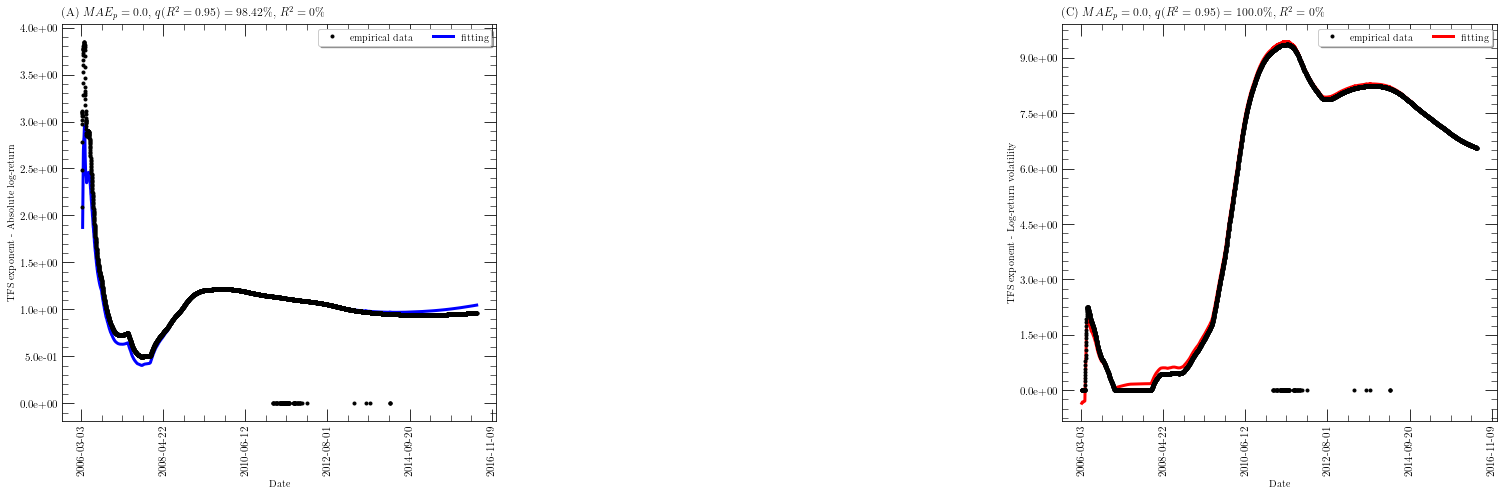

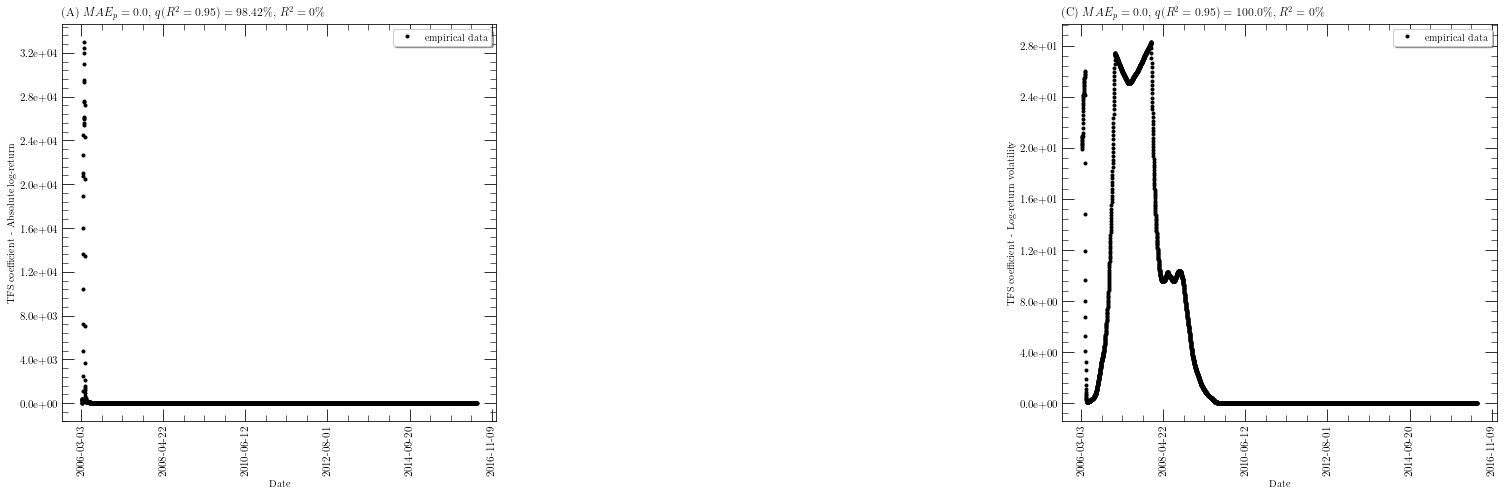

Generated plot for CNY=X and time series absolute log-return
Generated plot for CNY=X and time series log-return
Generated plot for CNY=X and time series log-return volatility


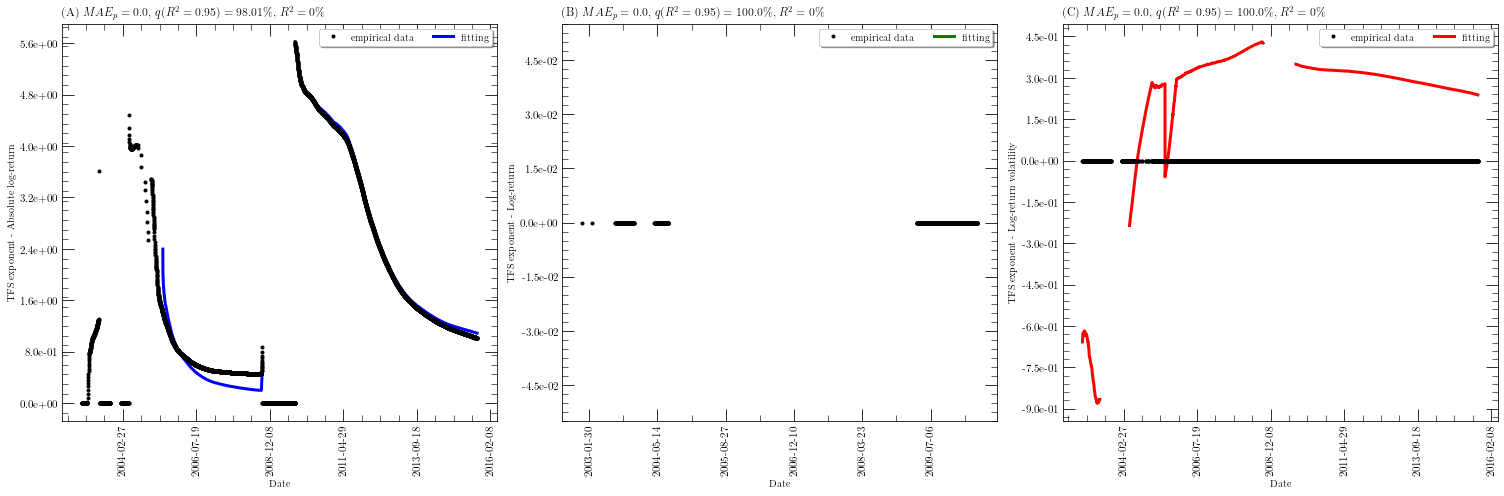

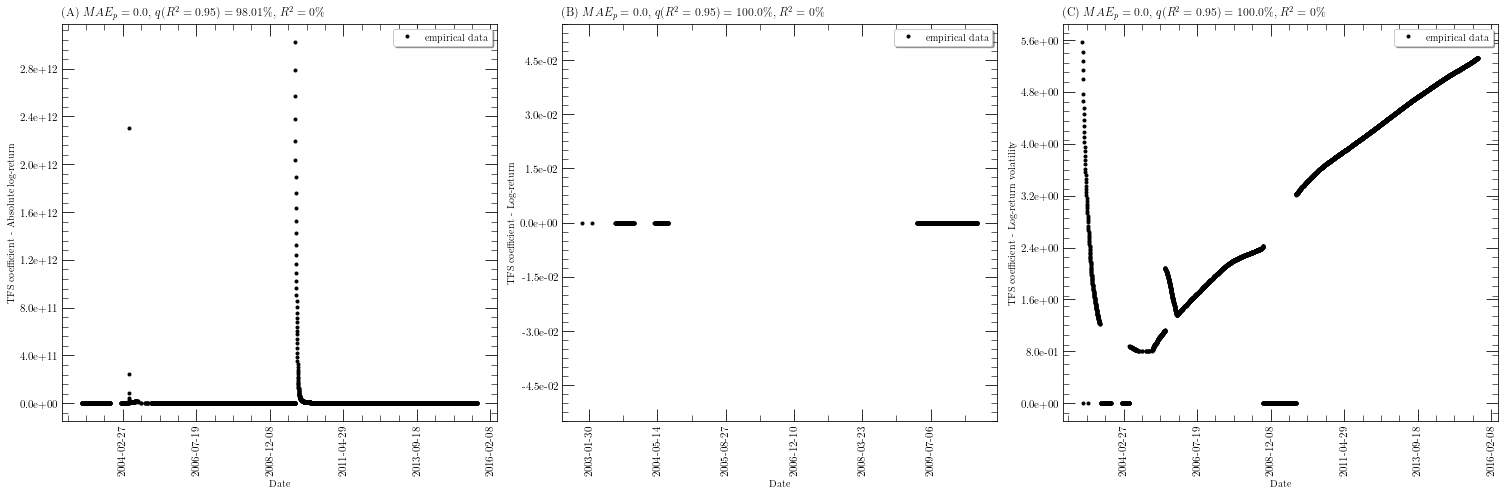

Generated plot for SEK=X and time series absolute log-return
Generated plot for SEK=X and time series log-return volatility


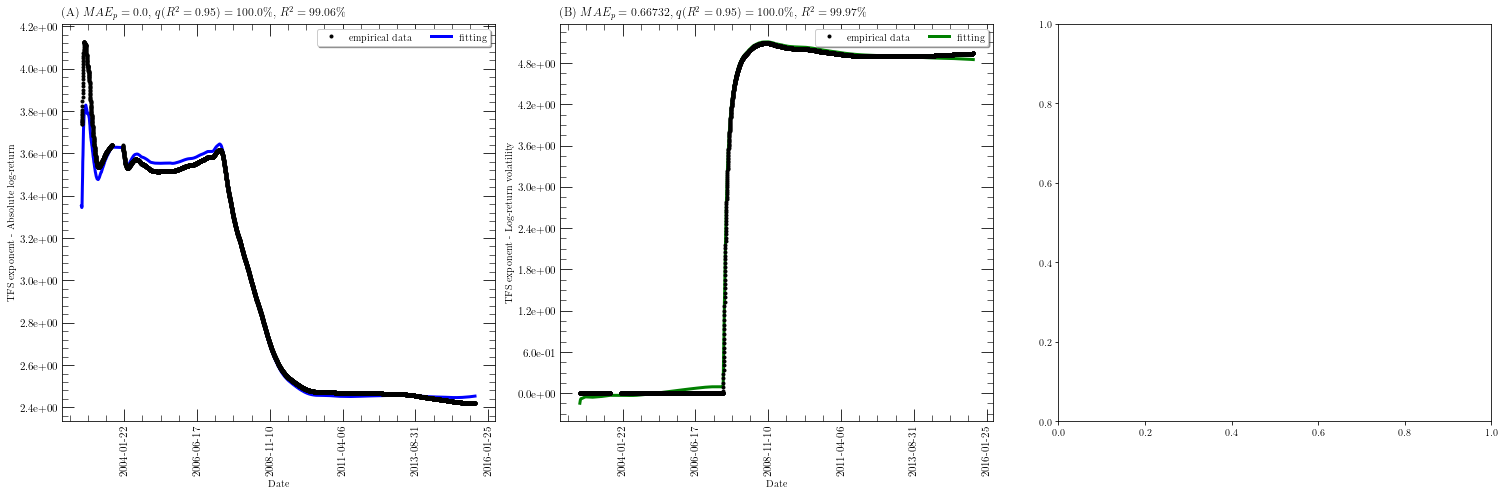

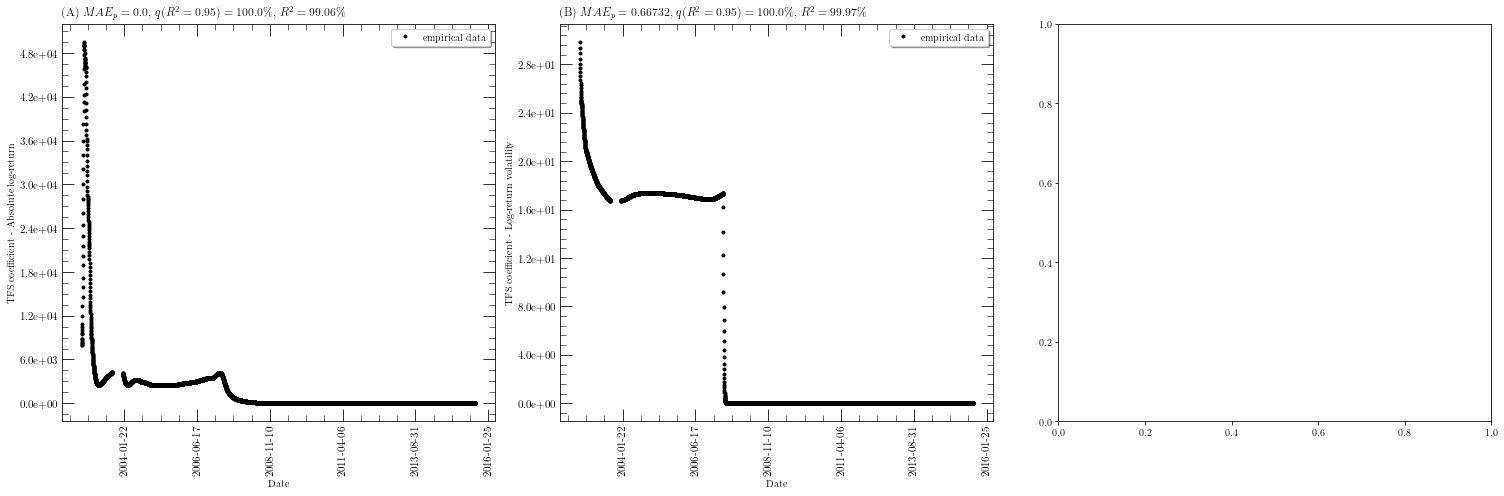

Generated plot for ZAR=X and time series absolute log-return
Generated plot for ZAR=X and time series log-return volatility


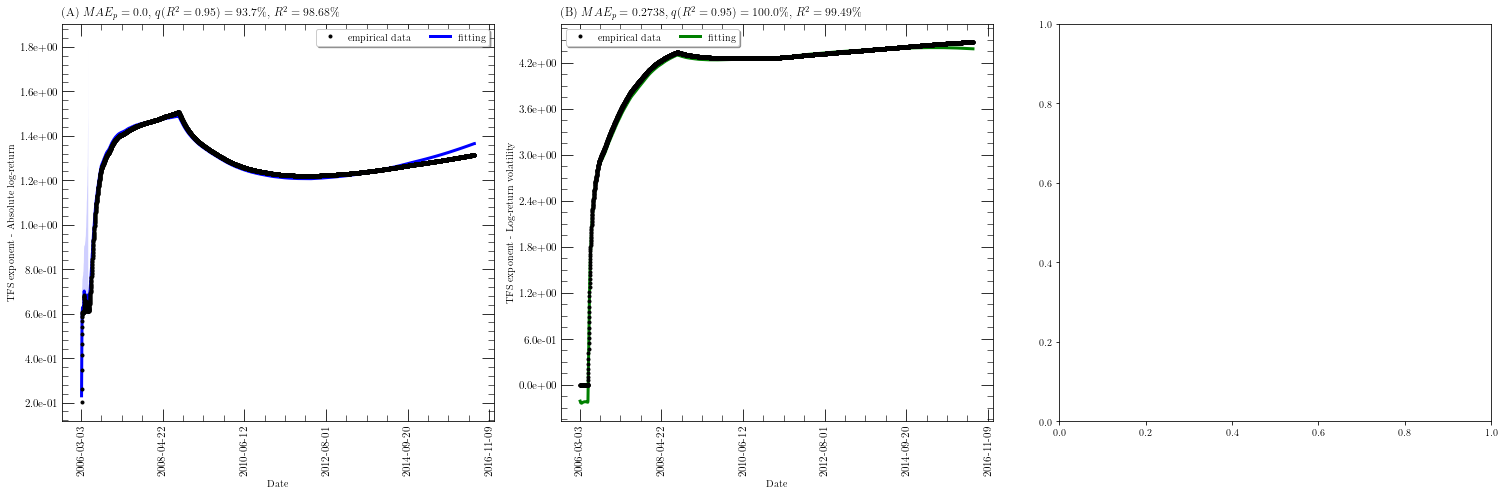

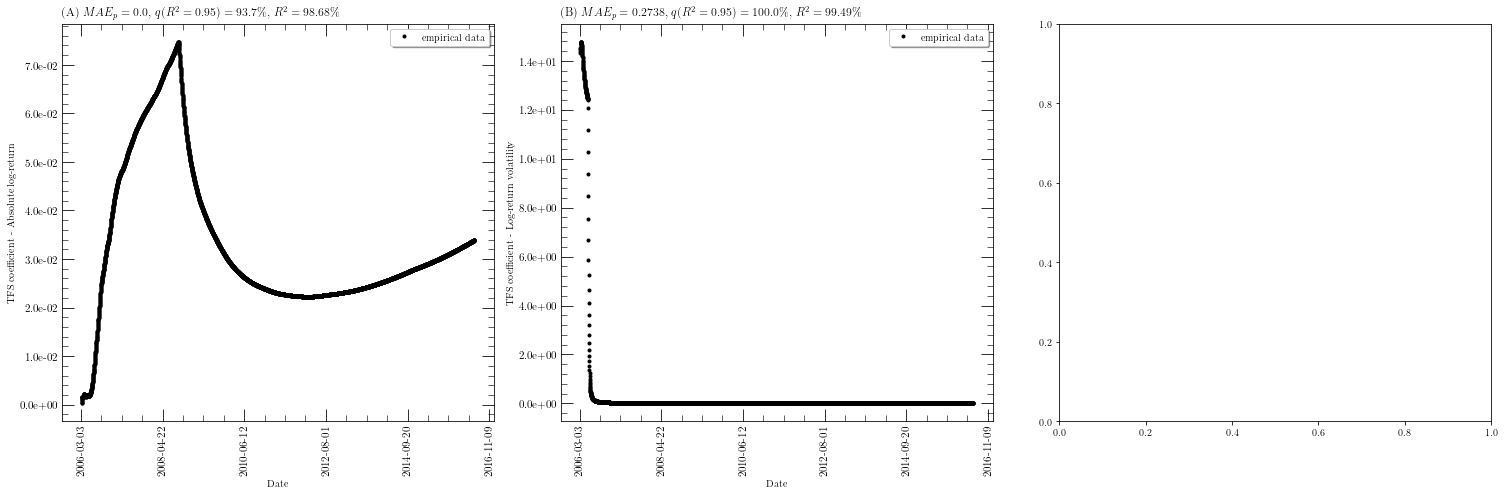

Generated plot for MXN=X and time series absolute log-return
Generated plot for MXN=X and time series log-return volatility


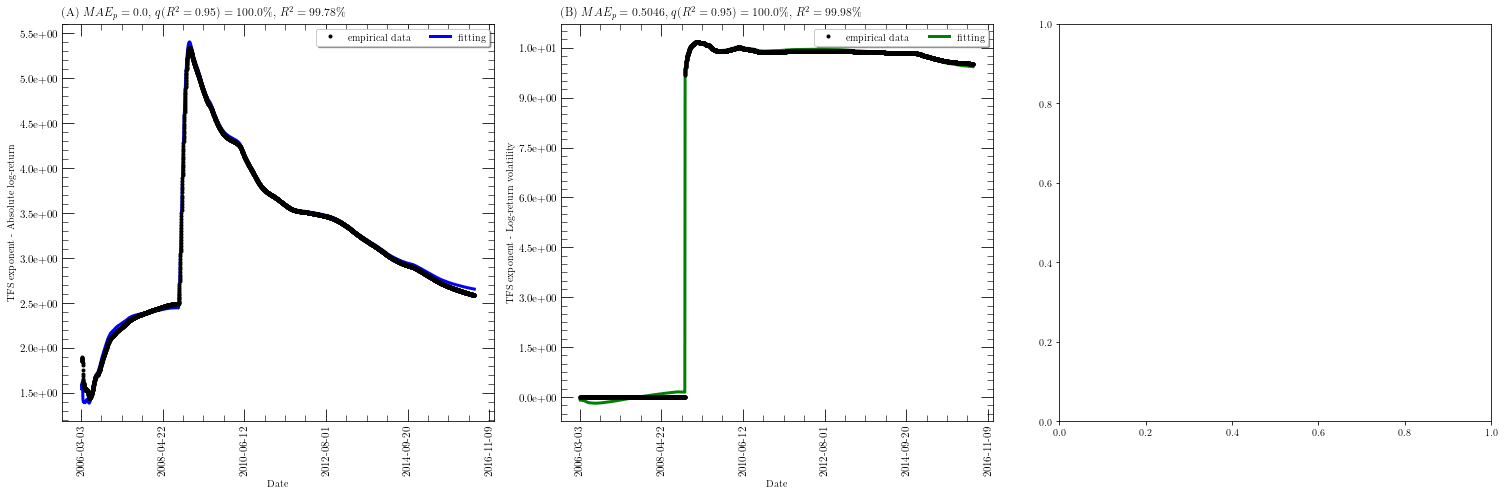

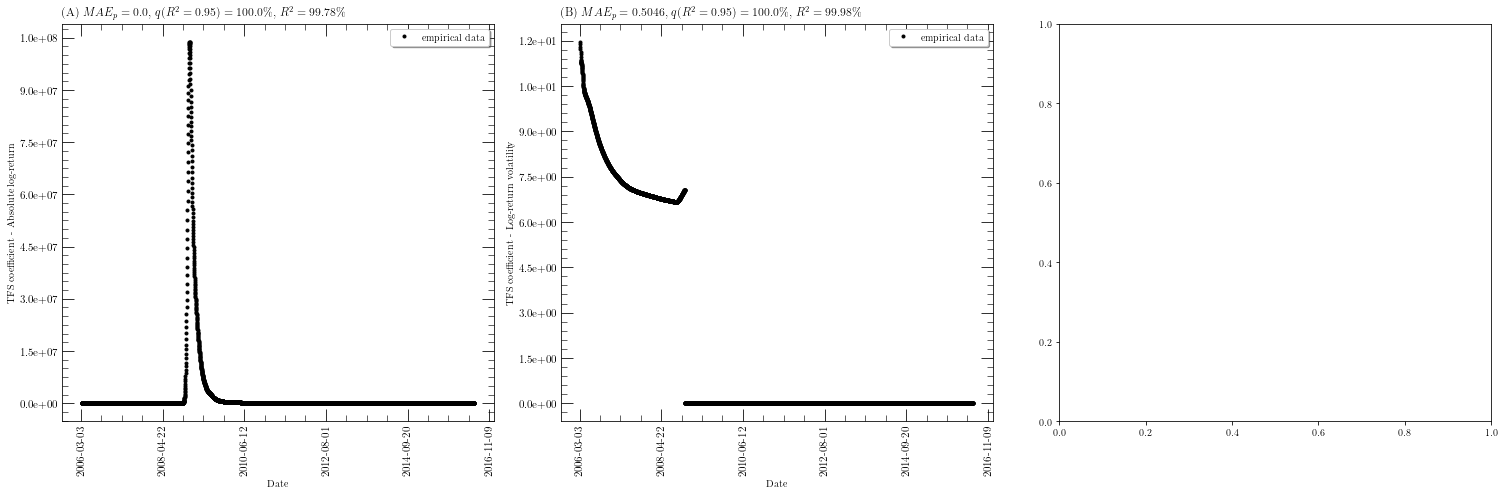

Generated plot for THB=X and time series absolute log-return
Generated plot for THB=X and time series log-return volatility


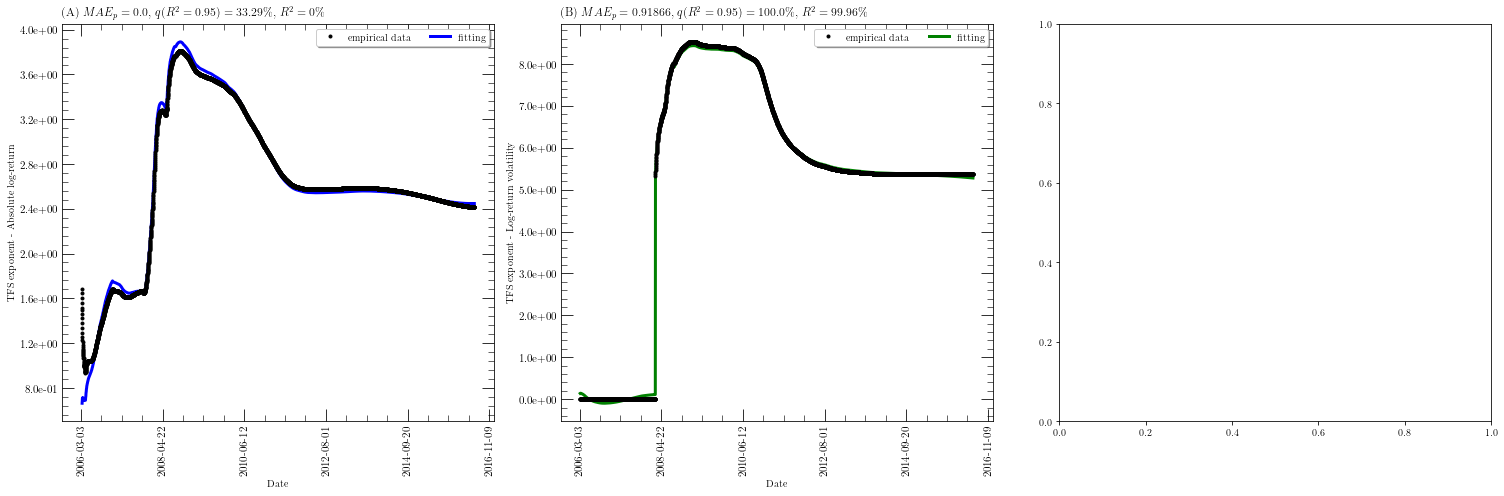

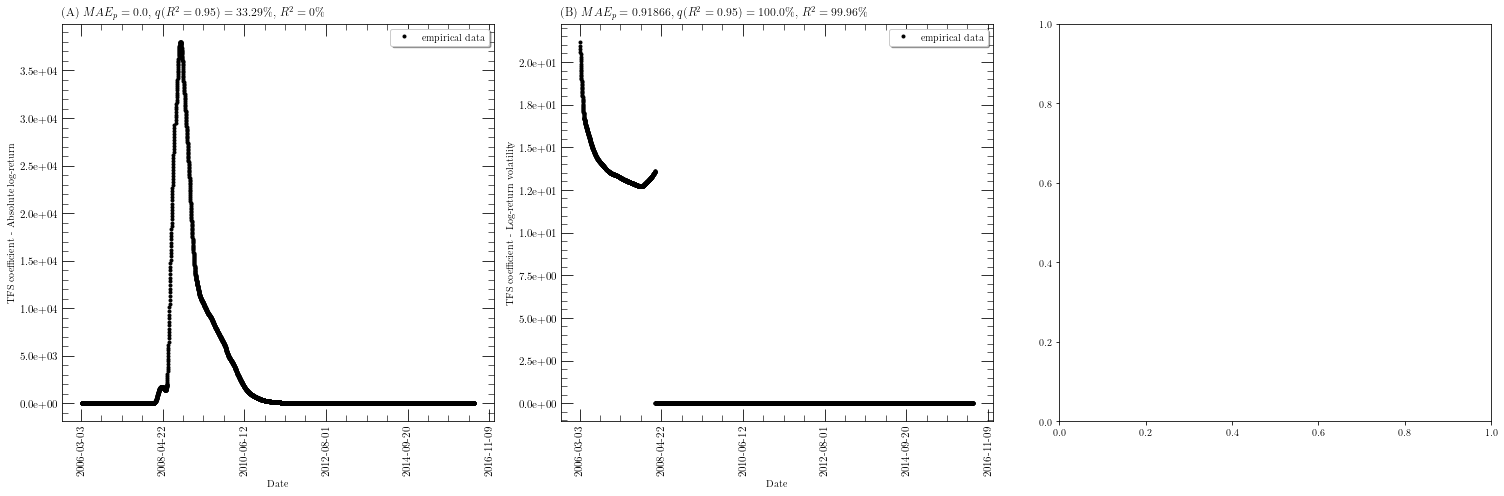

Generated plot for PHP=X and time series absolute log-return
Generated plot for PHP=X and time series log-return volatility


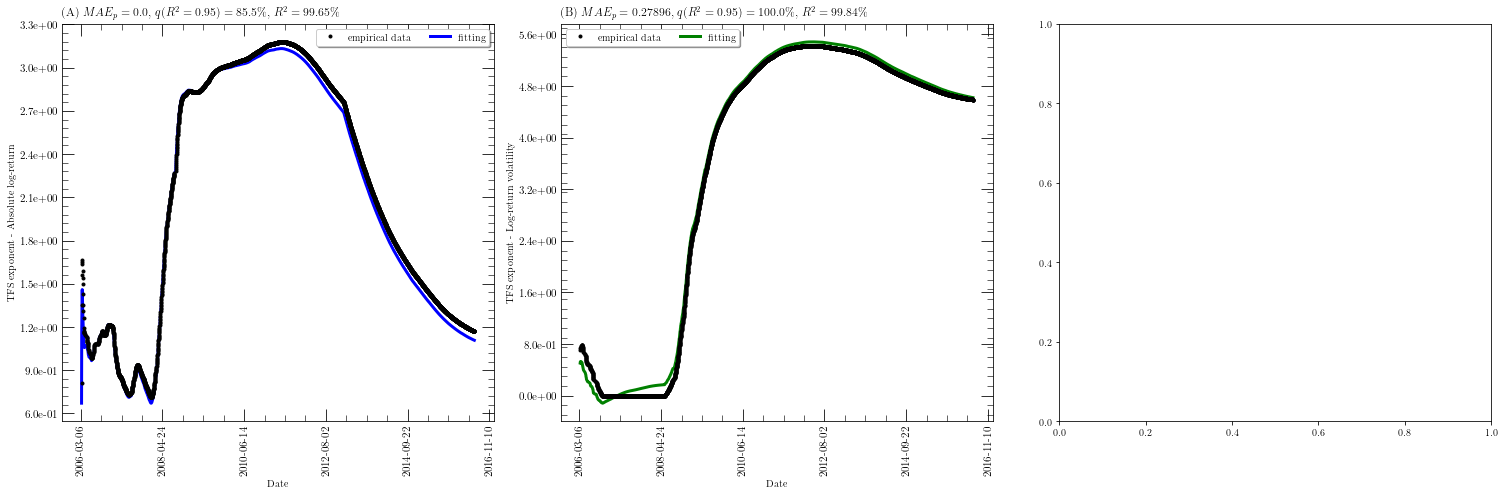

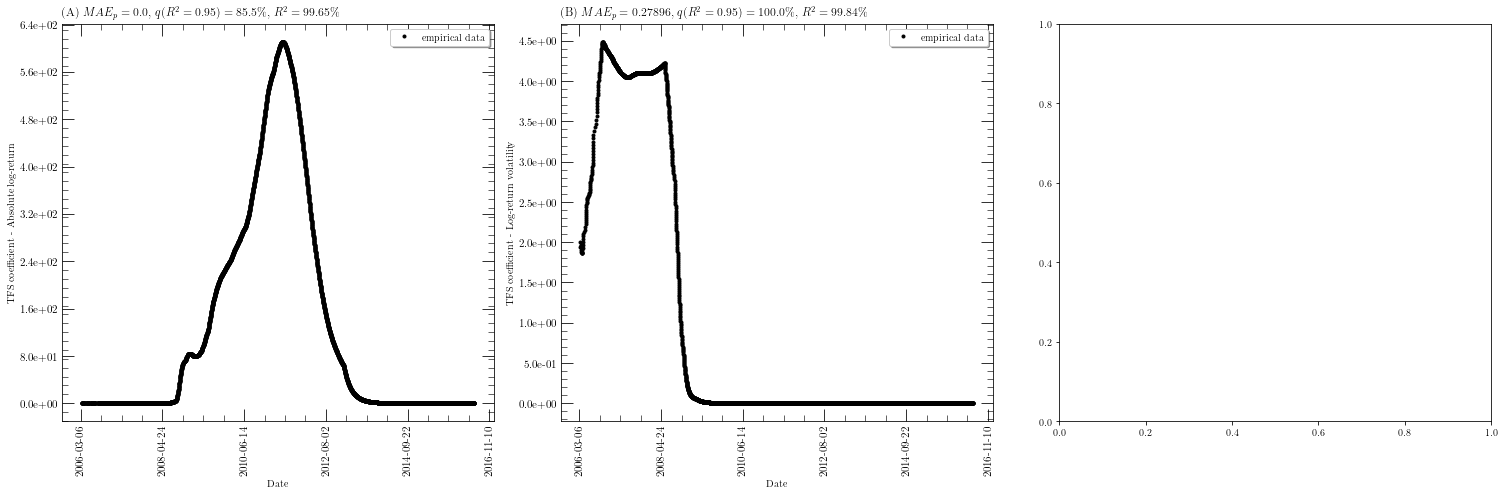

Generated plot for RUB=X and time series absolute log-return
Generated plot for RUB=X and time series log-return
Generated plot for RUB=X and time series log-return volatility


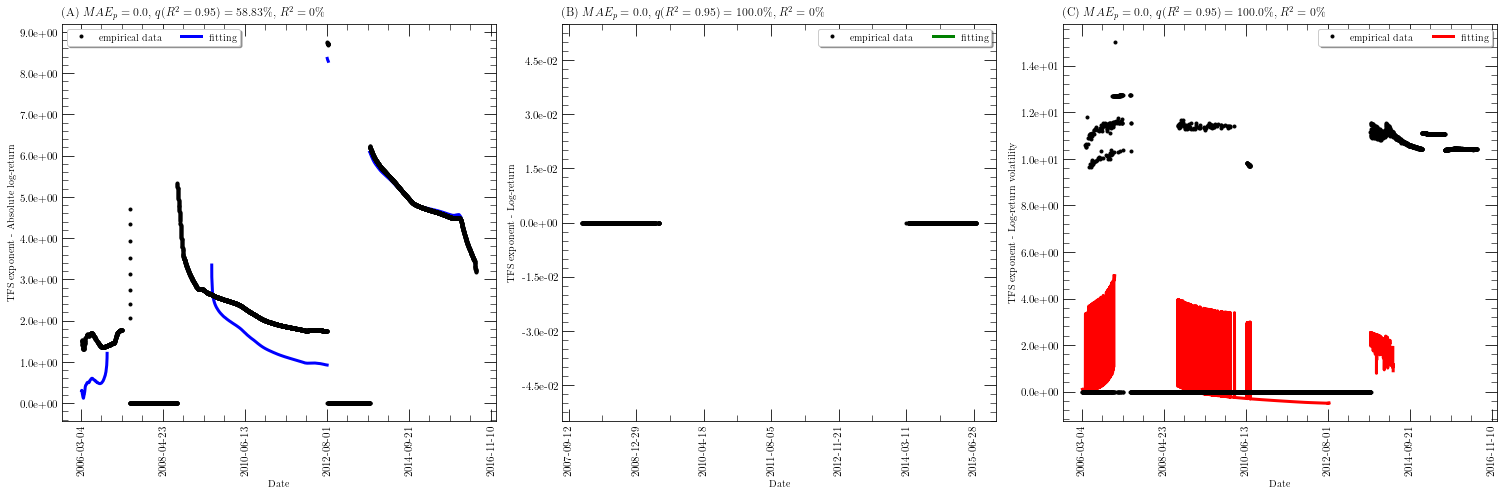

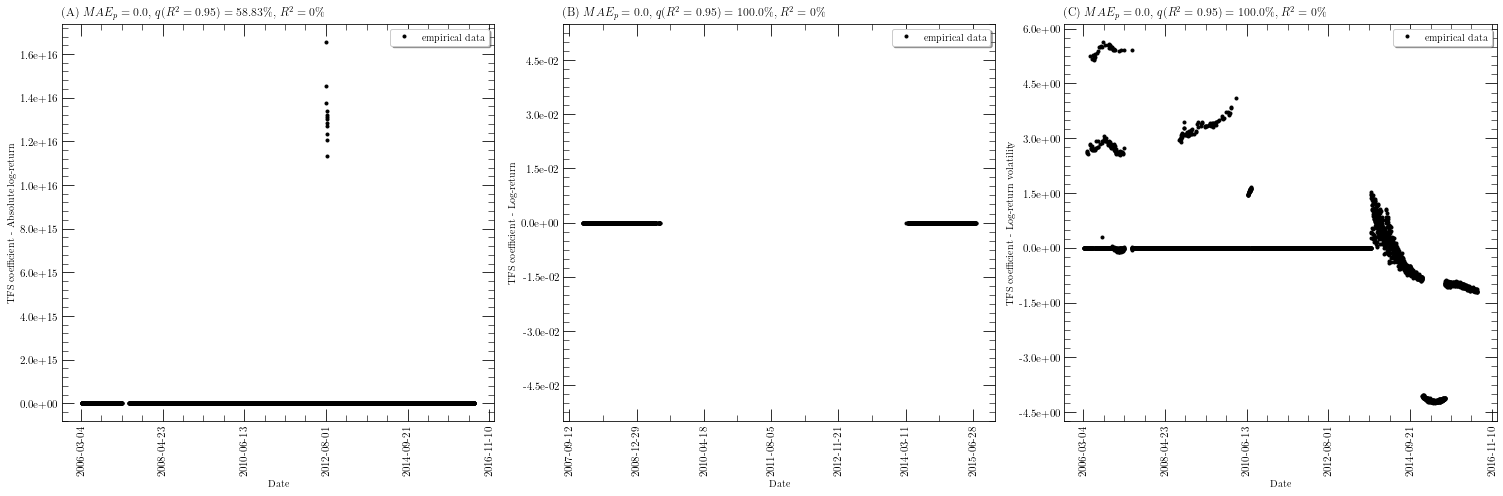

Generated plot for INR=X and time series absolute log-return
Generated plot for INR=X and time series log-return volatility


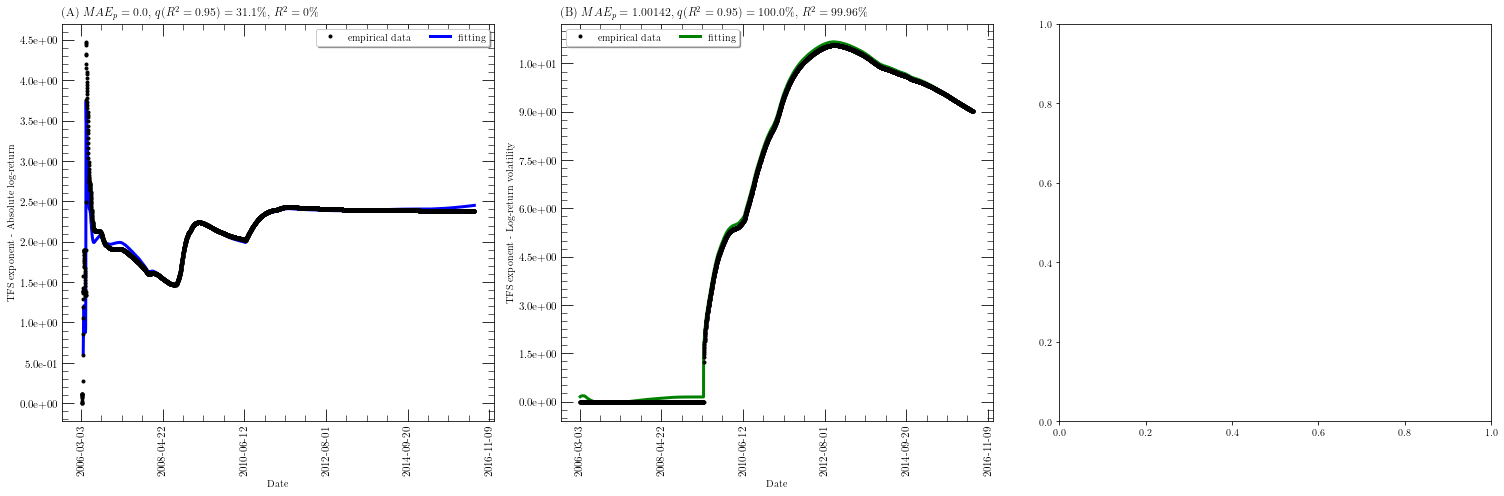

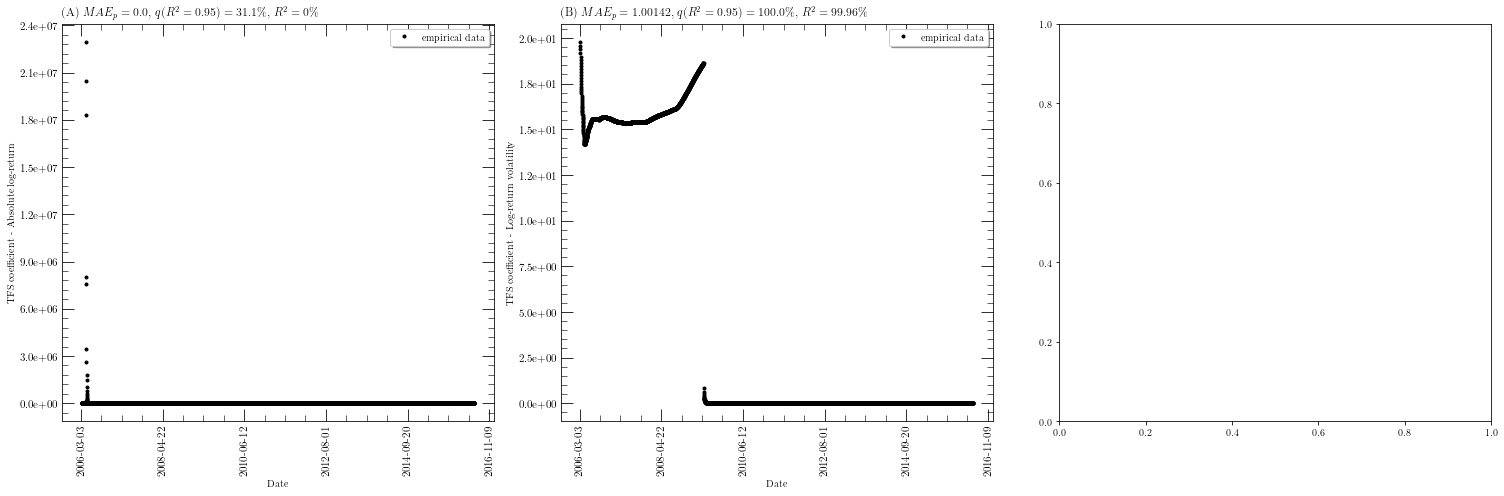

Generated plot for JPY=X and time series absolute log-return
Generated plot for JPY=X and time series log-return volatility


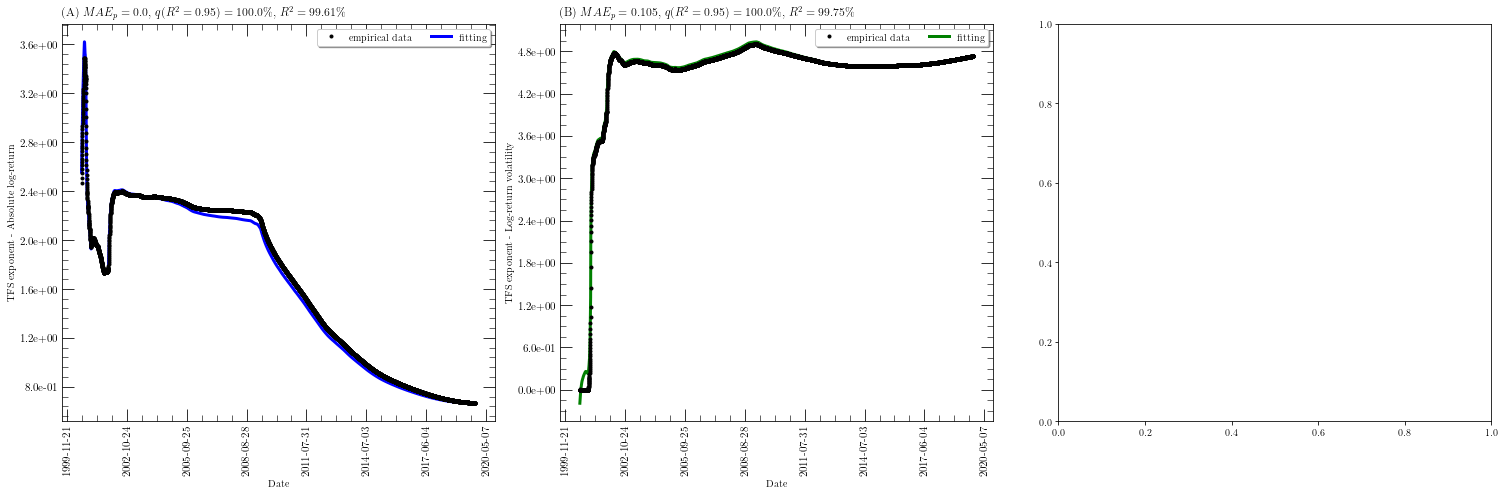

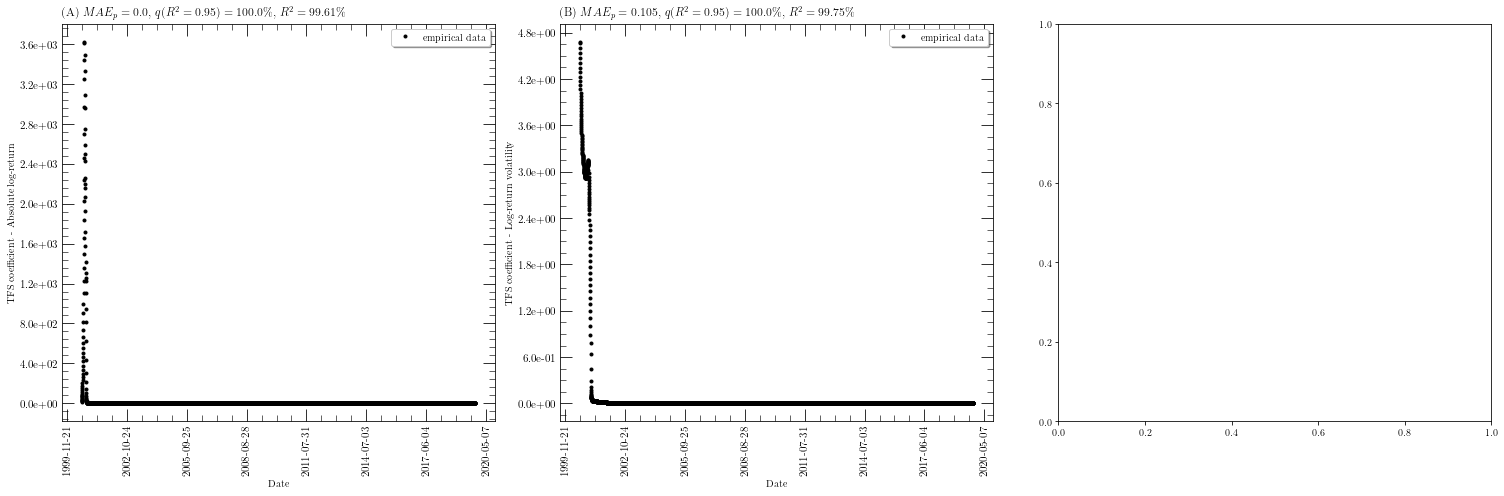

Generated plot for HUF=X and time series absolute log-return
Generated plot for HUF=X and time series log-return
Generated plot for HUF=X and time series log-return volatility


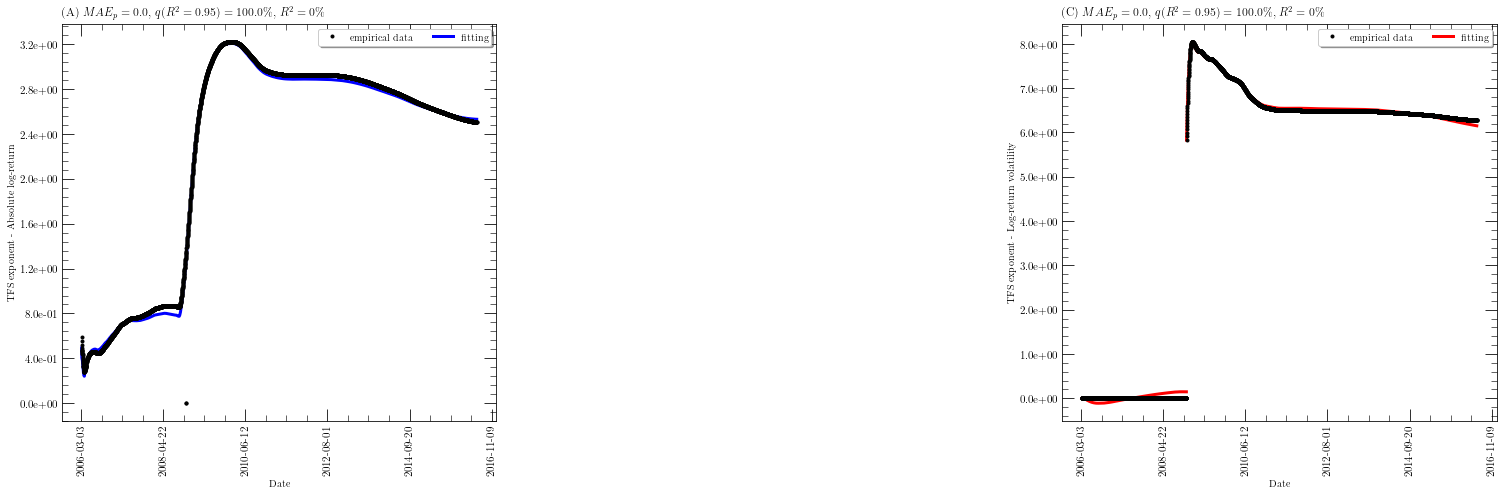

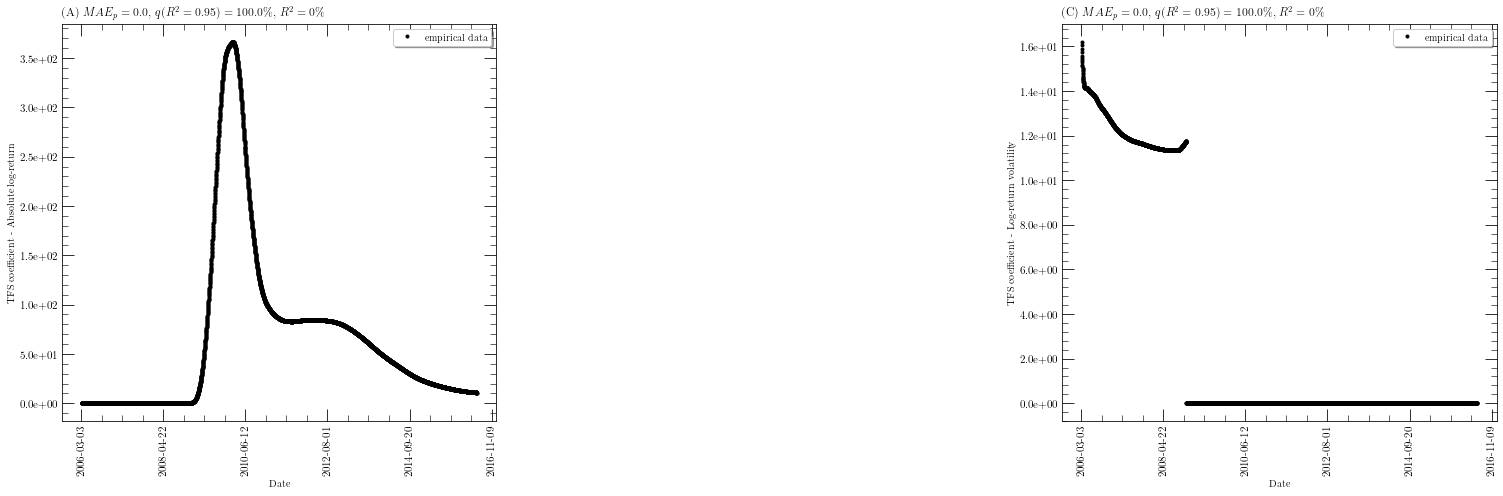

Generated plot for IDR=X and time series absolute log-return
Generated plot for IDR=X and time series log-return volatility


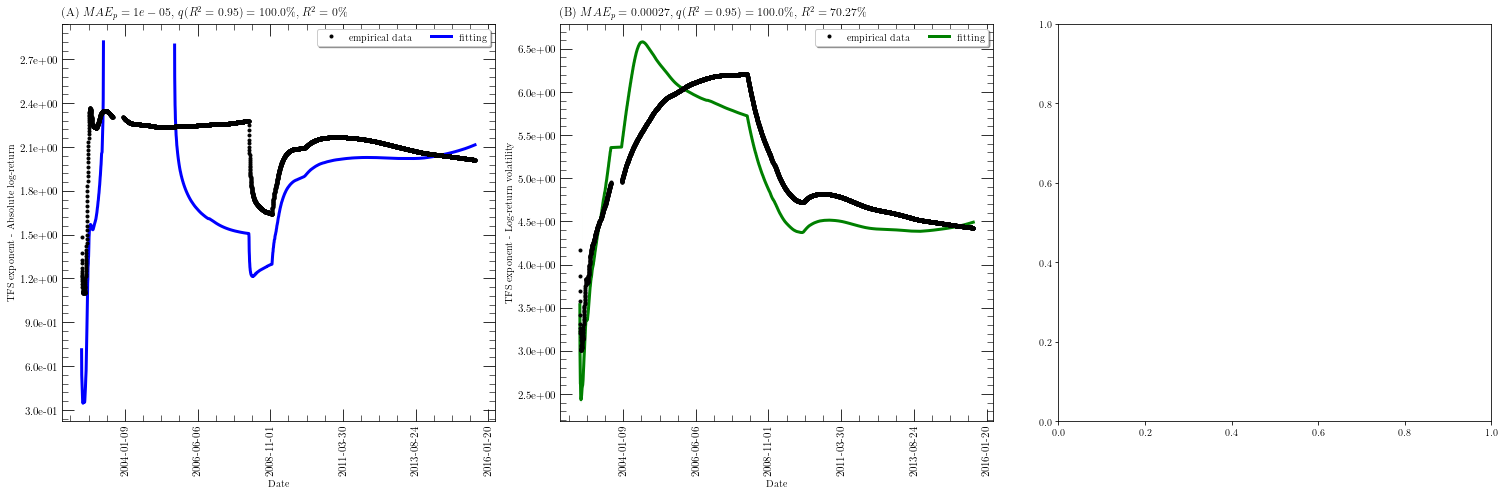

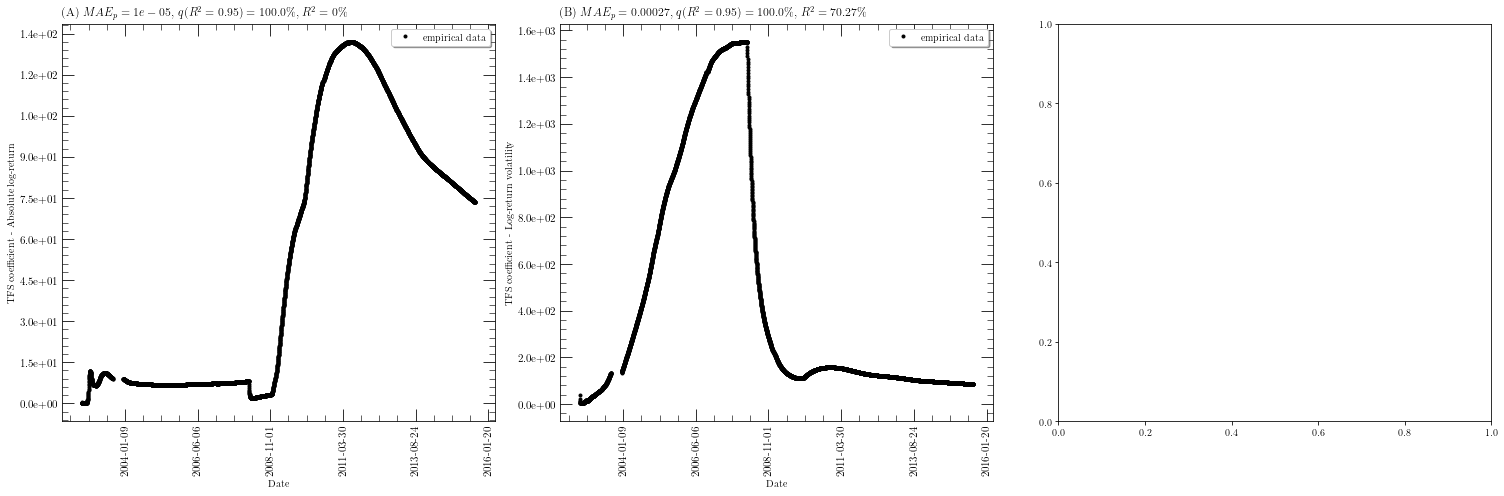

Generated plot for EURCOP=X and time series absolute log-return


TypeError: Improper input: func input vector length N=3 must not exceed func output vector length M=1

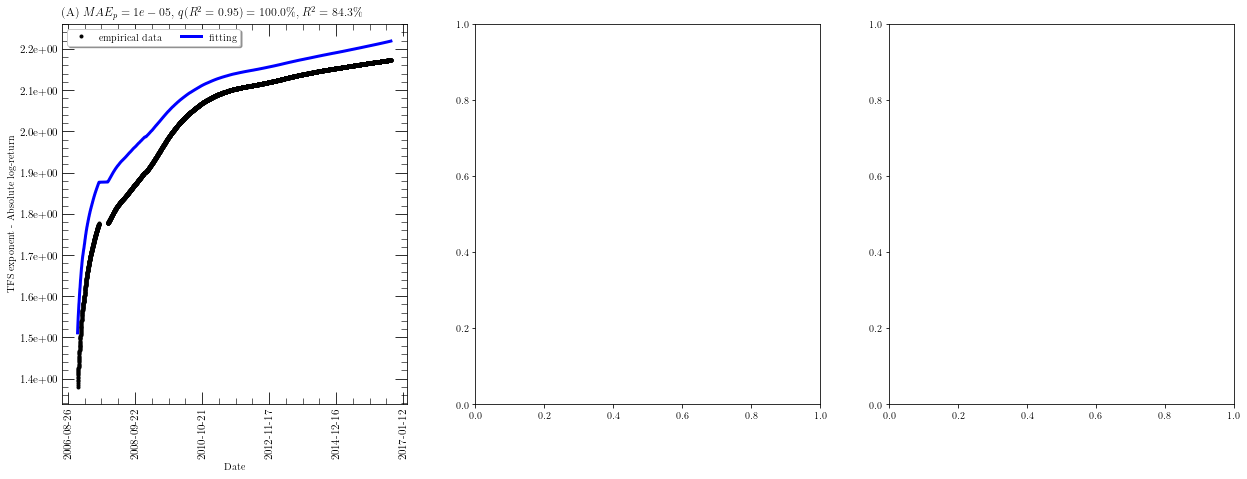

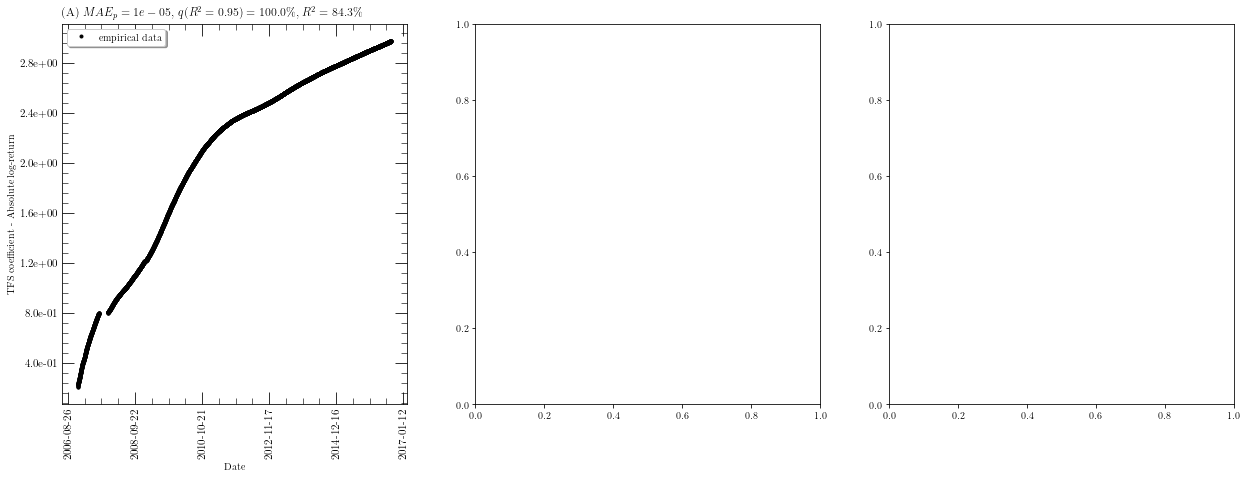

In [10]:
for ticker, ticker_name in list_currencies.items():
    if ticker not in ["BRL=X", "HKD=X", "COP=X"]:
        df_graph = plt_tfs.plot_tfs_evolution(
            df_fts = df_currencies,
            df_optimal = df_optimal_currencies,
            df_tfs = df_currencies_tfs_parameters,
            interval = "days",
            threshold = 0.95,
            symbols = [ticker],
            width = 21,
            height = 7,
            all_data = True,
            markersize = 3,
            fontsize_labels = 11,
            fontsize_legend = 10,
            usetex = True,
            n_cols = 4,
            n_x_breaks = 10,
            n_y_breaks = 10,
            fancy_legend = True,
            dpi = 200,
            save_figures = True,
            output_path = "{}/{}/currency".format(output_path, re.sub("-", "", input_generation_date)),
            information_name = re.sub("(\^)|(=X)", "", ticker),
            input_generation_date = input_generation_date
        )